In [17]:
# Imports

# Own Packages
from Masterarbeit_utils.model_utils import get_tokenizer, load_and_modify_model, load_pretrained_Tokenizer

# Site-Packages
import dask.dataframe as dd
import torch
import psutil
import os
import sys
import pickle as pk
import pandas as pd
import numpy as np
import bokeh
import time
import random
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from cProfile import Profile
from pstats import SortKey, Stats

# Dimension reduction algorithms
#from cuml.manifold import TSNE
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import export_png

from transformers import AutoTokenizer, OPTForCausalLM
from tokenizers.processors import TemplateProcessing
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset
from tensorboard.backend.event_processing import event_accumulator

%matplotlib inline
output_notebook()

Loading BokehJS ...

In [18]:
import sklearn
sklearn.__version__

'1.3.0'

# !!! Base model !!!

In [19]:
# Model config
"""
The Paths to important folders have to be changed for your system.
"""

# Name of this experiment
model_name = 'gal_125_aug_1'
checkpoint = 148000
# If True normalization is applied to the embeddings
norm = True


# This folder will be created and filled with txt files for each sample after you run the Pytorch Dataset Notebook
dataset_folder = f'data/dataset_samples'

# The folder at which the model will be saved. This folder has to be created for your system 
model_folder = f'data/models/{model_name}'
os.makedirs(model_folder, exist_ok=True)


# Folder in which the tokenizer will be saved
tokenizer_folder = f'data/tokenizers/{model_name}'
os.makedirs(tokenizer_folder, exist_ok=True)

# Folder at which all pickle files are stored. This folder is fixed for this project and should not be changed
dump_dir = r'PK_DUMP'

# Model parameters 
'''
mini	125 M
base	1.3 B
standard	6.7 B
large	30 B
huge	120 B'''
base_model_name = 'mini'

# All new Torch-objects will be by default in this dtype
# if default_type = float16 fp16 must be False
default_dtype = torch.float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_default_dtype(default_dtype)

# Default device on which the model will be loaded
#default_device = 'cuda:0'
default_device = 'cpu'
# Number of GPUs the model will be parallelised to 
num_gpus = 1
# If you change 'default_device' to 'cpu', make sure to set num_gpus to zero.
if default_device == 'cpu':
    num_gpus = 0

tensor_parallel = False



## Loss Curve

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['train/loss', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss'], 'distributions': [], 'tensors': ['args/text_summary', 'model_config/text_summary'], 'graph': False, 'meta_graph': False, 'run_metadata': []}
last eval ScalarEvent(wall_time=1692202967.8270805, step=100000, value=5.065518379211426)
last smoothed value 5.04450008392334


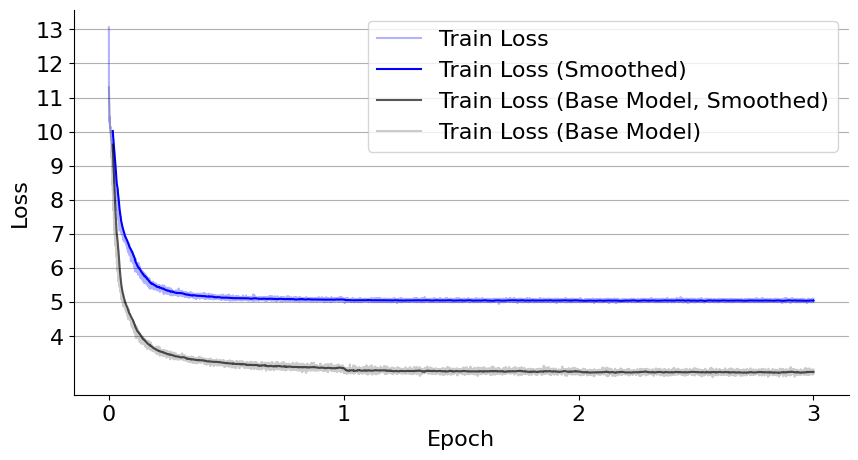

'data/models/gal_125_aug_1/loss_plot.svg'

In [6]:
# indices to navigate the runs folder and subfolders.
run = 0
event = 0

log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[event]

# Set the font to Helvetica size 12
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16


def convert_to_epoch(steps, epochs):
    #normalizing  to  one
    steps /= list(steps)[-1]
    # converting to epohc
    steps *= epochs
    return steps

# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() # Load the events from the file
print(ea.Tags())


# Extract scalar events for training and evaluation loss
train_loss_events = ea.Scalars('train/loss')
try:
    eval_loss_events = ea.Scalars('eval/loss')
    print('last eval', eval_loss_events[-1])
except Exception: 
    print('No Eval loss found')
    

# Convert to DataFrame for easy manipulation
train_steps = [event.step for event in train_loss_events]
train_values = [event.value for event in train_loss_events]

train_loss_df = pd.DataFrame({'step': train_steps, 'value': train_values})
train_loss_df['step'] = convert_to_epoch(train_loss_df['step'], 3)

# Calculate the rolling mean for smooth curves
smoothed_train_values = train_loss_df['value'].rolling(window=50).mean()


# compare data from base_model
run = 0
event = 0
model_folder_base = f'data/models/gal_125_1'
log_paths_base = os.listdir(f'{model_folder_base}/runs')
log_folder_base = log_paths_base[run]
log_file_base = os.listdir(f'{model_folder_base}/runs/{log_folder_base}')[0]
ea_base = event_accumulator.EventAccumulator(f'{model_folder_base}/runs/{log_folder_base}/{log_file_base}')
ea_base.Reload() # Load the events from the file
train_loss_events_base = ea_base.Scalars('train/loss')

# Convert to DataFrame for easy manipulation
train_steps_base = [event.step for event in train_loss_events_base]
train_values_base = [event.value for event in train_loss_events_base]

train_loss_df_base = pd.DataFrame({'step': train_steps_base, 'value': train_values_base})
train_loss_df_base['step'] = convert_to_epoch(train_loss_df_base['step'], 3)
# Calculate the rolling mean for smooth curves
smoothed_train_values_base = train_loss_df_base['value'].rolling(window=50).mean()
#####



print('last smoothed value', list(smoothed_train_values)[-1])
    
# Create the plot
plt.figure(figsize=(10,5))

# Plot the original training loss with transparency
plt.plot(train_loss_df['step'], train_loss_df['value'], alpha=0.3, color='blue', label='Train Loss')
plt.plot(train_loss_df['step'], smoothed_train_values, color='blue', label='Train Loss (Smoothed)')
plt.plot(train_loss_df_base['step'], smoothed_train_values_base, alpha=0.66, color='black', label='Train Loss (Base Model, Smoothed)')
plt.plot(train_loss_df_base['step'], train_loss_df_base['value'], alpha=0.2, color='black', label='Train Loss (Base Model)')



# Set up the y-axis to show each whole number and add horizontal gridlines
try:
    plt.yticks(np.arange(int(min(train_values + eval_values + train_values_base )), int(max(train_values + eval_values + train_values_base)) + 1  , 1.0))
except Exception:
    plt.yticks(np.arange(int(min(train_values )), int(max(train_values)) + 1  , 1.0))

plt.grid(axis='y')

# Customize the plot to remove the box, leaving just the x and y-axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(np.arange(0, max(train_loss_df['step']) + 1, 1))

#plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the plot as an SVG file
svg_filename = f'{model_folder}/loss_plot.svg'
plt.savefig(svg_filename, format='svg', bbox_inches='tight')

plt.show()

# Return the path to the saved SVG file
svg_filename

In [ ]:
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

run = 0
event = 0

log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[0]

# Matplotlib settings
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16

# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() 

# Extract text_summary
text_summary_tag = 'args/text_summary'  # or 'model_config/text_summary', depending on which you want to view
text_summary = ea.Tensors(text_summary_tag)

# Process and display the text summary
for summary in text_summary:
    tensor_proto = summary.tensor_proto
    tensor = tf.make_ndarray(tensor_proto)
    text_data = tensor.item().decode('utf-8')
    print(text_data)

## Accuracy

In [ ]:
# Loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')

# Loading the model
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
         _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available


model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                           device_map=device_map, max_memory=max_memory)

# Loading the dataset
class JapPatDataset(Dataset):
    """Dataset containing Japanese patents and their F-Term classification"""
    def __init__(self, data_folder, tokenizer):
        """
        data_folder: path to folder containing the text samples
        tokenizer: tokenizer instance with added additional Tokens for F-Terms
        """
        super(Dataset).__init__()
        self.data_folder = data_folder
        # This has to be manually set to the ammount of files in the 'dataset_samples' folder. Calculating the number of files in this folder would take forever.
        # A to low number would lead to samples missing from the dataset.
        # A to high number would raise a FileNotFound error.
        self.l = len(os.listdir(data_folder)) - 1
        #self.l = 10000
        self.tokenizer = tokenizer
        
    def __len__(self):
        return self.l
    
    def __getitem__(self, idx):
        try:
            with open(f'{self.data_folder}/{idx}.txt', 'r', encoding='utf-8') as f:
                item = f.read()
        except FileNotFoundError:
            
            raise FileNotFoundError
        
        # Tokenizing the item 
        # The Tokenizer will return a dict with the encoded text as 'input_ids', 
        # a mask which shows the tokens types this will not be needed for our applications
        # and a mask for the attention mechanism as 'attention_mask' The attention mask will be needed to indicate, that the 
        # model should not attend to <pad> tokens.
        
        output = self.tokenizer(item)  
        output.pop('token_type_ids')
        return output


train_dataset = JapPatDataset(f'{dataset_folder}/train', tokenizer)
validation_dataset = JapPatDataset(f'{dataset_folder}/validation', tokenizer)

# Loading a dict that contains the definitions of the f-terms
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)

In [ ]:
def classic_accurracy(batch, model, top_k=1):
    """
    Classic prediction accuracy metric. 
    This function should be applied to a batch of samples,
    which were tokenized by a tokenizer instance.
    This function returns the procentual accuracy metric as well as the total number of correct predictions
    and the total number of predictions in this batch

    :batch: batch of samples from validation dataset
    :model: model which should be testet
    :top_k: top k predictions which should be investigated for a correct result.
    """
    with torch.no_grad():
        model.eval()
        logits = model(**batch, output_hidden_states=False, return_dict=True)['logits']

    input_ids = batch['input_ids']
    # Removing first label
    labels = input_ids[:, 1:]
    # removing last prediction
    logits = logits[:, :-1]
    # Sorting the logits to get the predictions orderd from highest to lowest
    _, preds = torch.sort(logits, dim=-1, descending=True)
    # Dropping all text predictions and labels, keeping just the predictions and labels for f-terms
    token_threshold = 50000 # tokens with an ids_value below the token_threshold are removed
    preds = preds[labels > token_threshold]
    # only taking the top k predictions:
    preds = preds[:,:top_k]
    # the predictions are missing the 50000 text tokens so the predictions have to be increased by 50000
    preds += 50000
    labels = labels[labels > token_threshold]
    n_preds = labels.shape[0] # number of values that are to be predicted

    # expanding the labels to the same size as the predictions
    labels = labels.unsqueeze(dim=-1)
    labels = labels.expand(-1, top_k)
    n_correct = len(labels[labels == preds])
    accuracy = 100*n_correct/n_preds
    return accuracy, n_correct, n_preds
    

class Batch_DataLoader():
    """
    This class converts a dataset to a iterable dataloader, which loads padded patches of data.   
    """
    def __init__(self,
                 dataset, 
                 batchsize=10,
                 datacollator=DataCollatorWithPadding(tokenizer, return_tensors='pt')):

        self.dataset = dataset
        self.batchsize = batchsize
        self.l = len(dataset)//batchsize + 1
        self.datacollator = datacollator
        self.current = 0

    def __len__(self):
        return self.l

    def __iter__(self):
        self.current = 0
        return self

    def __next__(self):
        batch = [self.dataset[i] for i in range(self.current, self.current+self.batchsize)]
        batch = self.datacollator(batch)
        self.current += self.batchsize
        return batch
        

def accuracy_on_dataset(dataset, model, top_k=1, batch_size=10, batches = 20):
    loader = Batch_DataLoader(dataset, batch_size)
    n_pred = 0
    n_corr = 0
    for i, batch in enumerate(loader):
        if i == batches: break
        acc, corr, pred = classic_accurracy(batch, model, top_k)
        n_pred += pred
        n_corr += corr
        print(f'batch_acc: {acc:.2f}%, total_acc: {100*n_corr/n_pred:.2f}% batch {i}/{len(loader)}', end ='\r')
    
    return n_pred, n_corr
    



In [ ]:
b_dl = Batch_DataLoader(validation_dataset, 50)

for batch in b_dl:
    break

with torch.no_grad():
    model.eval()
    logits = model(**batch, output_hidden_states=False, return_dict=True)['logits']

input_ids = batch['input_ids']
# Removing first label
labels = input_ids[:, 1:]
logits = logits[:, :-1]
 # Sorting the logits to get the predictions orderd from highest to lowest
_, preds = torch.sort(logits, dim=-1, descending=True)


In [ ]:


for t, p in zip(labels, preds):
    p = p[:, 0]
   
    p = p[t >= 50000]
    t = t[t >= 50000]
    print('Prediction', tokenizer.decode(p +  50000))
    print('Target', tokenizer.decode(t))
    print('')
    

In [ ]:
n_pred, n_corr = accuracy_on_dataset(validation_dataset, model, top_k=1, batch_size=50, batches = 2)

## t-SNE plots

In [ ]:
context_less = True
###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available
             
model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loadede Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/themes_descriptions.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/viewpoints_descriptions.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/numbers_descriptions.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
        full_descriptions_dict = pk.load(f)

###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()


#Embeddings if the model is not a sequence classification model
out_emb = model.get_output_embeddings()
out_emb = next(out_emb.parameters()).to('cpu').detach().numpy()[2:]
inp_emb = inp_emb(torch.arange(len(tokenizer))).to('cpu').detach().numpy()[50002:]

if context_less:
    # Extracting context less embeddings
    if not os.path.isfile(f'{model_folder}/context_less_emb.pk'):
        print('Calculating context less embeddings!')
        context_less_emb = [[] for _ in range(13)]
        for i in range(len(tokenizer)):
            print(i, end='\r')
            out = model(input_ids= torch.tensor([[i]]), attention_mask = torch.tensor([[1]]), output_hidden_states=True)
                
            out = out.hidden_states
            for i, k in enumerate(out):
                context_less_emb[i].append(k.to('cpu').detach().numpy())
        with open(f'{model_folder}/context_less_emb.pk', 'wb') as f:
            pk.dump(context_less_emb, f)
    else:
        print('Loading context less embeddings from disk')
        with open(f'{model_folder}/context_less_emb.pk', 'rb') as f:
            context_less_emb = pk.load(f)
        
    # Combining context less embeddings of a layer to a single tensor
    for i, layer in enumerate(context_less_emb):
        layer = [e[0] for e in layer]
        layer = np.concatenate(layer, 0)
        context_less_emb[i] = layer


    

## Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)
if context_less:
    context_less_emb = [normalize(layer) for layer in context_less_emb]

# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

# Creating  a dict with f-Terms and their embedding vectors:

out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}
inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}

if context_less:
    # Creating Context Less Embedding Dicts
    context_less_dicts = []
    for layer in context_less_emb:
        context_less_dicts.append({token[:-1]: vec for token, vec in zip(tokens, layer)})

In [ ]:
# Calculating the TSNE Representation of all output embeddigns
if os.path.isfile(f'{model_folder}/output_emb_tsne_{checkpoint}.pk'):
    print('loading TSNE Representation from disk!')
    with open(f'{model_folder}/output_emb_tsne_{checkpoint}.pk', 'rb') as f:
        out_tsne = pk.load(f)
else:
    print('Calculating TSNE Representation (takes up to an hour)')
    tsne = TSNE(n_components=2, verbose=0, random_state=69) 
    tsne_rep = tsne.fit_transform(out_emb)
    with open(f'{model_folder}/output_emb_tsne_{checkpoint}.pk', 'wb') as f:
        pk.dump(tsne_rep, f)
    out_tsne = tsne_rep


# Calculating the TSNE Representation of all input embeddigns
if os.path.isfile(f'{model_folder}/input_emb_tsne_{checkpoint}.pk'):
    print('loading TSNE Representation from disk!')
    with open(f'{model_folder}/input_emb_tsne_{checkpoint}.pk', 'rb') as f:
        inp_tsne= pk.load(f)
else:
    print('Calculating TSNE Representation (takes up to an hour)')
    tsne = TSNE(n_components=2, verbose=0, random_state=69) 
    tsne_rep = tsne.fit_transform(inp_emb)
    with open(f'{model_folder}/input_emb_tsne_{checkpoint}.pk', 'wb') as f:
        pk.dump(tsne_rep, f)
    inp_tsne = tsne_rep

tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

if context_less:
    # Calculating or loading the TSNE Representations for the last layer
    layer_tsne_reps = []
    i = len(context_less_emb)
    emb = context_less_emb[0]
    if os.path.isfile(f'{model_folder}/output_tsne_rep_{checkpoint}_layer{i}.pk'):
        print('Loading TSNE representation for layer ', i)
        with open(f'{model_folder}/output_tsne_rep_{checkpoint}_layer{i}.pk', 'rb') as f:
            layer_tsne_reps.append(pk.load(f))
    else:
        print('Calculating TSNE representation for layer ', i)
        tsne = TSNE(n_components=2, verbose=0, random_state=69) 
        tsne_rep = tsne.fit_transform(emb)
        with open(f'{model_folder}/output_tsne_rep_{checkpoint}_layer{i}.pk', 'wb') as f:
                    pk.dump(tsne_rep)
        layer_tsne_reps = [tsne_rep]
# Dropping Text tokens
if context_less:
    last_layer_tsne = layer_tsne_reps[50000:]
#inp_tsne = inp_tsne[50000:]

In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

themes = [t[:5] for t in tokens[50000:]]
print(len(themes))

with open(f'{model_folder}/themes.pk', 'wb') as f:
    pk.dump(themes, f)

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
ax.axis('on')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(out_tsne[:, 0], out_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/out_free_tsne_pretty.png' # Saving in writable directory
#plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

In [ ]:
def plot_tsne_cutout(x_range, y_range, out_tsne, point_colors, themes):
    """
    Function to plot a cutout of the t-SNE scatter plot with annotations for every 30th appearance of each theme.
    
    Parameters:
    x_range (tuple): A tuple of (start, stop) for x-axis range.
    y_range (tuple): A tuple of (start, stop) for y-axis range.
    out_tsne (np.array): The t-SNE output array.
    point_colors (list): List of colors for each point in the scatter plot.
    themes (list): List of themes corresponding to each point.
    """
    filtered_points = []
    filtered_colors = []
    theme_counters = {}  # Dictionary to count occurrences of each theme
     # Create a new figure for the cutout plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')

    for i, (x, y, c, theme) in enumerate(zip(out_tsne[:, 0], out_tsne[:, 1], point_colors, themes)):
        if x_range[0] <= x <= x_range[1] and y_range[0] <= y <= y_range[1]:
            filtered_points.append((x, y))
            filtered_colors.append(c)
            theme_counters[theme] = theme_counters.get(theme, 0) + 1

            if theme_counters[theme] % 30 == 0:
                # Annotate every 30th occurrence of each theme
                ax.annotate(theme_dict[theme], (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    if not filtered_points:
        print("No points found in the specified range.")
        return

   
    # Scatter plot for the cutout
    ax.scatter([x for x, y in filtered_points], [y for x, y in filtered_points], s=10, color=filtered_colors, alpha=1)

    # Set the x and y limits based on the selected cutout region
    ax.set_xlim(x_range[0], x_range[1])
    ax.set_ylim(y_range[0], y_range[1])

    # Display the plot
    plt.show()

# Example usage
p = (-4, -132)
s = 20
x_range = (p[0], p[0] + s)  # replace with your x-axis range
y_range = (p[1], p[1] + s)  # replace with your y-axis range
plot_tsne_cutout(x_range, y_range, out_tsne, point_colors, themes)

In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

themes = [t[:5] for t in tokens[50002:]]
print(len(themes))

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(inp_tsne[:, 0], inp_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/inp_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

last_layer_tnse = layer_tsne_reps[0][50000:]
inp_tsne = inp_tsne[50000:]

themes = [t[:5] for t in tokens[50000:]]

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(last_layer_tsne[:, 0], last_layer_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/last_layer_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

## Histograms

In [20]:
seq_class = False
###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available

if seq_class:
    model = OPTForSequenceClassification.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)
else:
    model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/themes_descriptions.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/viewpoints_descriptions.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/numbers_descriptions.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)


###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()

if not seq_class:
    #Embeddings if the model is not a sequence classification model
    out_emb = model.get_output_embeddings()
    out_emb = next(out_emb.parameters()).to('cpu').detach().numpy()[2:]
    inp_emb = inp_emb(torch.arange(len(tokenizer))).to('cpu').detach().numpy()[50002:]
    
    # Extracting context less embeddings
    if not os.path.isfile(f'{model_folder}/context_less_emb.pk'):
        print('Calculating context less embeddings!')
        context_less_emb = [[] for _ in range(13)]
        for i in range(len(tokenizer)):
            print(i, end='\r')
            out = model(input_ids= torch.tensor([[i]]), attention_mask = torch.tensor([[1]]), output_hidden_states=True)
            
            out = out.hidden_states
            for i, k in enumerate(out):
                context_less_emb[i].append(k.to('cpu').detach().numpy())
        with open(f'{model_folder}/context_less_emb.pk', 'wb') as f:
            pk.dump(context_less_emb, f)
    else:
        print('Loading context less embeddings from disk')
        with open(f'{model_folder}/context_less_emb.pk', 'rb') as f:
            context_less_emb = pk.load(f)
    
    # Combining context less embeddings of a layer to a single tensor
    for i, layer in enumerate(context_less_emb):
        layer = [e[0] for e in layer]
        layer = np.concatenate(layer, 0)
        context_less_emb[i] = layer

else: 
    # embeddings if the model is a Sequence Classifier
    inp_emb = inp_emb(torch.arange(50000)).to('cpu').detach().numpy()
    out_emb = model.score.weight
    out_emb.to('cpu').detach().numpy()
    

## Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)
if not seq_class:
    context_less_emb = [normalize(layer) for layer in context_less_emb]

# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

# Creating  a dict with f-Terms and their embedding vectors:

out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}
if seq_class:
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(tokens[:50000], inp_emb)}
else: 
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}
    
# Creating Context Less Embedding Dicts
if not seq_class:
    context_less_dicts = []
    for layer in context_less_emb:
        context_less_dicts.append({token[:-1]: vec for token, vec in zip(tokens, layer)})


####################################################
# Detecting F-Term Pairs with Supposed Similarities
####################################################
df=pd.read_csv("data/f-terms.csv", index_col=0)

#subset with "material" in the viewpoint description
df2=df[df.viewpoint_label.str.contains("material",case=False, na=False)].copy()
df2["vp"]=df2.theme+"/"+df2.viewpoint
df2["fterm"]=df2.theme+"/"+df2.number

#f-term descriptions are searched for the following materials
materials_list=["metal", "wood", "concrete", "resin", "fiber", "wool", "sand", "cord", "copper", "iron", "silver", "gold", "lead", "glass", "stone", "titanium", "steel", "cement", "silicon", "polymer", "ceramics"]
materials_f_terms={}
for material in materials_list:
    materials_f_terms[material]=[df2[df2.label.str.contains(material,case=False, na=False)].vp.unique(), df2[df2.label.str.contains(material,case=False, na=False)].fterm.values]

#pairs of two materials with fterms in same viewpoints are created
material_combinations={}
for mat1 in materials_list:
    for mat2 in materials_list:
        
        if mat1==mat2: continue
        if mat2+"_"+mat1 in materials_f_terms: continue
        
        #filtering shared f-terms with both materials in the label description
        
        unique_fterms_mat1 = list(set(materials_f_terms[mat1][1]) - set(materials_f_terms[mat2][1]))
        unique_fterms_mat2 = list(set(materials_f_terms[mat2][1]) - set(materials_f_terms[mat1][1]))


        vp_mat1= set([x[:8]for x in unique_fterms_mat1])
        vp_mat2= set([x[:8]for x in unique_fterms_mat2])
        shared_vp=[x for x in vp_mat1 if x in vp_mat2]
        fterm_pairs=[]
        for vp in shared_vp:
            fterm_pairs.append([vp,
                                [fterm for fterm in unique_fterms_mat1 if fterm.startswith(vp)][:1],
                                [fterm for fterm in unique_fterms_mat2 if fterm.startswith(vp)][:1]])
            
            
        material_combinations[mat1+"_"+mat2]=fterm_pairs

Loaded Tokenizer from serialized instance!
There are 378166 different F-Terms in the whole Dataset!
Loading context less embeddings from disk


In [21]:
emb = out_emb_dict 
#layer_n = 13
#emb = context_less_dicts[layer_n]
# Dictionary that contains all differences and additional information for each material combination
differences = {}
# Huge dict, that contains the difference vectors as keys and 
diffs_dict = {}

for i, combination in enumerate(material_combinations.items()):
    key, item = combination
    print(i, key, end='\r')
    # Checking if the reverse combination was already calculated
    # Thank god i thought of that, i was so panicing, that i was comparing vectors in both direcitions int hte out of comb similarities
    current_material_keys = []
    for current_key in differences.keys():
        current_material_keys.append(current_key.split('_'))
    combination_keys = key.split('_')
    combination_keys.reverse()
    if combination_keys in current_material_keys:
        continue

    # Calculating the differences and storing them in a list of dict
    combinations_list = []
    for viewpoint_comb in item:
        viewpoint, mat_1, mat_2 = viewpoint_comb
        for f_term_1 in mat_1:
            for f_term_2 in mat_2:
                try: 
                    vec_1 = emb[f_term_1]
                    vec_2 = emb[f_term_2]
                    diff = vec_2 - vec_1
                    diff = normalize(np.array([diff]))[0]                   
                    sample_dict = {}
                    sample_dict['Vector'] = diff
                    sample_dict['Viewpoint'] = viewpoint
                    sample_dict['F-Term 1'] = f_term_1
                    sample_dict['F-Term 2'] = f_term_2
                    diffs_dict[sys.intern(str(np.sum(diff)))] = [viewpoint, f_term_1, f_term_2]
                    combinations_list.append(sample_dict)
                except KeyError:
                    continue
    # Now the differences are computed and stored in a list of dicts
    differences[key] = combinations_list         


# Pairing the vectors to compare

max_comb = 100000000
sqr_max_comb = int(max_comb**0.5)
in_combination_comparisons = {}

for i, [keys, samples] in enumerate(differences.items()):
    # Adding the comparison of the material combination with itself to the comparisons
    in_combination_comparisons[keys] = {'Vectors A': [], 
                                        'Vectors B': [],
                                        'Viewpoints': [],
                                        'F-Terms A': [],
                                        'F-Terms B': []}
    print(i, keys, len(samples), end = '\r')
    samples_2 = list(samples)
    random.shuffle(samples_2)
    s1 = 0 
    while len(samples_2) > 0:
        s1 += 1
        s2 = 0
        sample_a = samples_2.pop(0)
        random.shuffle(samples_2)
        for sample_b in samples_2:

            if s2 == sqr_max_comb:
                break
            # Ignoring combinations with matching Viewpoints
            if sample_a['Viewpoint'] == sample_b['Viewpoint']:
                continue
            # Debugging remove later 
            ##################################
            vpa = sample_a['Viewpoint']
            vpb = sample_b['Viewpoint']
            theme_a = vpa.split('/')[0]
            theme_b = vpb.split('/')[0]
            if theme_a == theme_b:
                continue
            ###################################
            in_combination_comparisons[keys]['Vectors A'].append(torch.tensor(np.array([sample_a['Vector']])))
            in_combination_comparisons[keys]['Vectors B'].append(torch.tensor(np.array([sample_b['Vector']])))
            in_combination_comparisons[keys]['Viewpoints'].append([sample_a['Viewpoint'], sample_a['Viewpoint']])
            in_combination_comparisons[keys]['F-Terms A'].append([sample_a['F-Term 1'], sample_a['F-Term 2']])
            in_combination_comparisons[keys]['F-Terms B'].append([sample_b['F-Term 1'], sample_b['F-Term 2']])
            s2 += 1
        if s1 == sqr_max_comb:
            break

            
# Calculating the Cosine Similarities within all combinations
cos = torch.nn.CosineSimilarity(dim =1)
bad_keys = []
min_comb = 2000

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    print(' '*1000, end='\r')
    print(i, key, end = '\r')
    try:
        similarities = cos(torch.cat(combination_dict['Vectors A'], 0), torch.cat(combination_dict['Vectors B'], 0))
        # Dropping combinations with low sample counts
        if len(similarities) < min_comb:
            print('Low number of samples in:', key, len(similarities), end='\r')
            bad_keys.append(key)
            continue
        combination_dict['Cosine Similarities'] = np.array(similarities)
        # Creating a sorted index of the similariteis to compare the best ones with other combinations
        combination_dict['Sort idx'] = np.argsort(np.array(similarities))[::-1]
        
        
    except RuntimeError:
        print(' '*1000, end='\r')
        print('Empty combination dictionary found, dropping  it!', key, end='\r')
        bad_keys.append(key)
        continue
        

for key in bad_keys:
    in_combination_comparisons.pop(key)

    
# Extracting the best vectors 
for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    top_100 = np.array(combination_dict['Cosine Similarities'])
    idx = combination_dict['Sort idx'][:100]
    top_100 = top_100[idx]
    # Top 100 vectors a
    top_vectors = np.concatenate(combination_dict['Vectors A'], 0)[idx]
    top_vectors = np.concatenate([np.concatenate(combination_dict['Vectors B'], 0)[idx], top_vectors])
    # dropping duplicates
    top_vectors = np.unique(top_vectors, axis = 0)    
    combination_dict['Best Vectors']  = top_vectors
    print(' '*1000, end='\r')
    print(i, key, len(top_vectors), end='\r')  


# Computing the cosine similarities for out of combination comparisons

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    #print(' '*1000, end='\r')
    #print(i, key, end=' \r')
    #print(i, key)
    
    # Extracting all unique vectors from other material combinations, which do not share a material with the material 
    # Combination to be checked
    all_vectors = []
    material_1, material_2 = key.split('_')
    for key2, samples in differences.items():
        
        materials2 = key2.split('_')
        # Ignoring material combinations with matching materials 
        if material_1 in materials2 or material_2 in materials2:
            continue
        # Ignoring material combinations which do not appear in the in_combination_comparisons keys
        if not key2 in [k for k in in_combination_comparisons.keys()]:
            continue
        
        for sample_dict in samples:
            all_vectors.append(sample_dict['Vector'])
            
    
    all_vectors = np.stack(all_vectors, 0)
    # removing duplicate vectors just to be sure
    all_vectors = np.unique(all_vectors, axis=0)
    np.random.shuffle(all_vectors)
    
    l = len(combination_dict['Cosine Similarities'])
    vectors_a , vectors_b = [], []
    top_vectors = list(combination_dict['Vectors A'])
    top_vectors.extend(combination_dict['Vectors B'])
    
    top_vectors = np.concatenate(top_vectors, 0)

    np.random.shuffle(top_vectors)
   

    for top_vector in top_vectors:
        vp, _ ,_ = diffs_dict[str(np.sum(top_vector))]
        if len(vectors_a) == l: 
            break
        for vector in all_vectors:
            if len(vectors_a) == l: 
                break
            vp2, _, _ = diffs_dict[str(np.sum(vector))]
            # Skipping vectors with the same viewpoints
            if vp2 == vp:
                continue
            ##### Debugging remove later
            theme_a = vp.split('/')[0]
            theme_b = vp2.split('/')[0]
            if theme_a == theme_b:
                continue
            #############################
            vectors_a.append(top_vector)
            vectors_b.append(vector)
            
    
    vectors_a = np.stack(vectors_a, 0)
    vectors_b = np.stack(vectors_b, 0)
   
    similarities = cos(torch.tensor(vectors_a), torch.tensor(vectors_b)).numpy()
    combination_dict['Out of Comb Simis'] = similarities



0.010160491 mean_in 3.350558e-05 meany_out


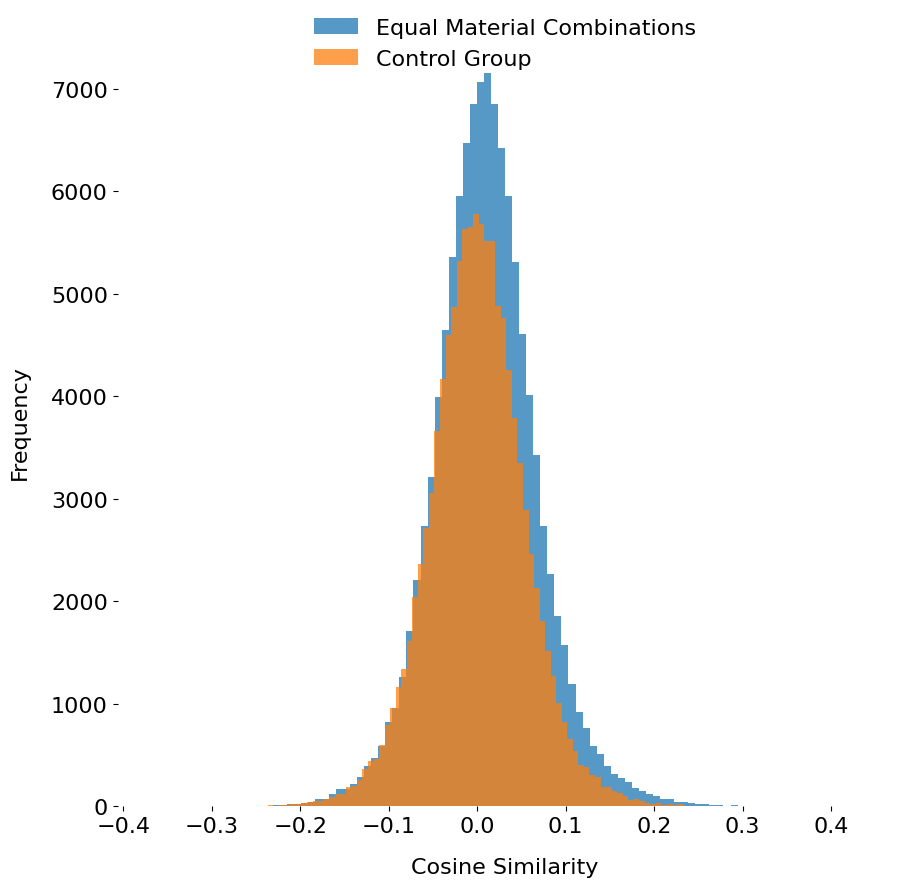

In [22]:
# Set the font to Helvetica size 12
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16


layer_n = f'Just one sample per viewpoint {vectors_a[0].shape}'
# Plotting all out of comb similarities vs all in comb similarities (combined)
all_in_comb = []
all_out_comb = []
for comb_dict in in_combination_comparisons.values():
    all_in_comb.extend(comb_dict['Cosine Similarities'])
    all_out_comb.extend(comb_dict['Out of Comb Simis'])

all_in_comb = np.array(all_in_comb)
all_out_comb = np.array(all_out_comb)
mean_in = np.mean(all_in_comb)
mean_out = np.mean(all_out_comb)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])

np.random.shuffle(all_out_comb)
axs.hist(all_in_comb, bins=100, alpha=0.75, label='Equal Material Combinations')
axs.hist(all_out_comb[-len(all_in_comb):], bins=100, alpha=0.75, label='Control Group')

axs.set_xlabel('Cosine Similarity', labelpad=15)
axs.set_ylabel('Frequency', labelpad=15)
axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), frameon=False)

# Remove the spines (borders)
for spine in axs.spines.values():
    spine.set_visible(False)

# Save the figure as an SVG file in the specified model folder
fig.savefig(f'{model_folder}/material_comb_hist.svg', format='svg')
print(mean_in, 'mean_in', mean_out, 'meany_out')
plt.show()





In [ ]:
mean_in - mean_out

# !!! Sequence Classification model !!!

In [9]:
# Additional imports
from Masterarbeit_utils.model_utils_seq_class import load_and_modify_model, get_tokenizer
from transformers import AutoTokenizer, AutoConfig, OPTForSequenceClassification
from tokenizers.processors import TemplateProcessing
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset

In [10]:
# Model config
"""
The Paths to important folders have to be changed for your system.
"""

# Name of this experiment
model_name = 'gal_125_seq_1'
checkpoint = 111057
# If True normalization is applied to the embeddings
norm = True


# This folder will be created and filled with txt files for each sample after you run the Pytorch Dataset Notebook
dataset_folder = f'data/dataset_samples'

# The folder at which the model will be saved. This folder has to be created for your system 
model_folder = f'data/models/{model_name}'
os.makedirs(model_folder, exist_ok=True)


# Folder in which the tokenizer will be saved
tokenizer_folder = f'data/tokenizers/{model_name}'
os.makedirs(tokenizer_folder, exist_ok=True)

# Folder at which all pickle files are stored. This folder is fixed for this project and should not be changed
dump_dir = r'PK_DUMP'

# Model parameters 
'''
mini	125 M
base	1.3 B
standard	6.7 B
large	30 B
huge	120 B'''
base_model_name = 'mini'

# All new Torch-objects will be by default in this dtype
# if default_type = float16 fp16 must be False
default_dtype = torch.float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_default_dtype(default_dtype)

# Default device on which the model will be loaded
default_device = 'cuda:0'
#default_device = 'cpu'
# Number of GPUs the model will be parallelised to 
num_gpus = 1
# If you change 'default_device' to 'cpu', make sure to set num_gpus to zero.
if default_device == 'cpu':
    num_gpus = 0

tensor_parallel = False


## Loss Curve

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['train/loss', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second'], 'distributions': [], 'tensors': ['args/text_summary', 'model_config/text_summary'], 'graph': False, 'meta_graph': False, 'run_metadata': []}


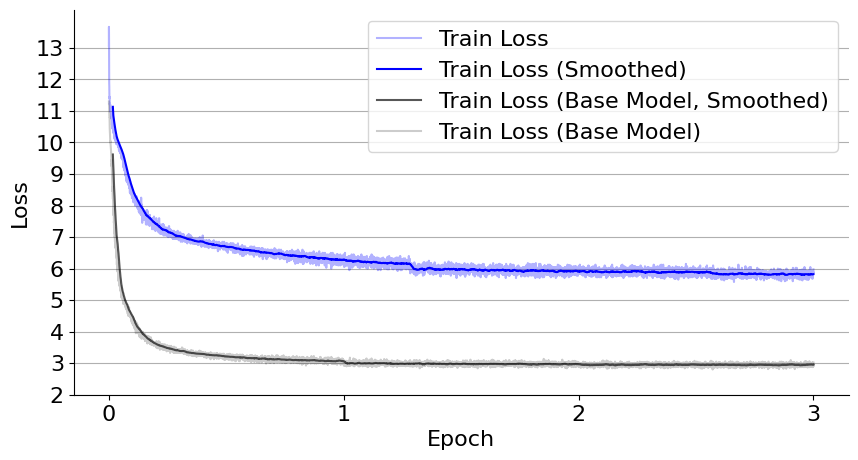

'data/models/gal_125_seq_1/loss seq.svg'

In [16]:
# indices to navigate the runs folder and subfolders.
run = 7  # 7
event = 0


def convert_to_epoch(steps, epochs):
    #normalizing  to  one
    steps /= list(steps)[-1]
    # converting to epohc
    steps *= epochs
    return steps


log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[0]

# Set the font to Helvetica size 12
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16


# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() # Load the events from the file

print(ea.Tags())

# Extract scalar events for training and evaluation loss
train_loss_events = ea.Scalars('train/loss')
try:
    eval_loss_events = ea.Scalars('eval/loss')
except Exception: 
    print('No Eval loss found')

# compare data from base_model
run = 0
event = 0
model_folder_base = f'data/models/gal_125_1'
log_paths_base = os.listdir(f'{model_folder_base}/runs')
log_folder_base = log_paths_base[run]
log_file_base = os.listdir(f'{model_folder_base}/runs/{log_folder_base}')[0]
ea_base = event_accumulator.EventAccumulator(f'{model_folder_base}/runs/{log_folder_base}/{log_file_base}')
ea_base.Reload() # Load the events from the file
train_loss_events_base = ea_base.Scalars('train/loss')

# Convert to DataFrame for easy manipulation
train_steps_base = [event.step for event in train_loss_events_base]
train_values_base = [event.value for event in train_loss_events_base]

train_loss_df_base = pd.DataFrame({'step': train_steps_base, 'value': train_values_base})
train_loss_df_base['step'] = convert_to_epoch(train_loss_df_base['step'], 3)
# Calculate the rolling mean for smooth curves
smoothed_train_values_base = train_loss_df_base['value'].rolling(window=50).mean()
train_values_base = train_loss_df_base['value']
#####
    
# Convert to DataFrame for easy manipulation
train_steps = [event.step for event in train_loss_events]
train_values = [event.value for event in train_loss_events]
try:
    eval_steps = [event.step for event in eval_loss_events]
    eval_values = [event.value for event in eval_loss_events]
except Exception: pass

train_loss_df = pd.DataFrame({'step': train_steps, 'value': train_values})
try:
    eval_loss_df = pd.DataFrame({'step': eval_steps, 'value': eval_values})
except Exception: pass

train_loss_df['step'] = convert_to_epoch(train_loss_df['step'], 3)

# Calculate the rolling mean for smooth curves
smoothed_train_values = train_loss_df['value'].rolling(window=50).mean()
try:
    smoothed_eval_values = eval_loss_df['value'].rolling(window=50).mean()
except Exception: pass

# Create the plot
plt.figure(figsize=(10,5))
plt.xticks(np.arange(0, max(train_loss_df['step']) + 1, 1))

# Plot the original training loss with transparency
plt.plot(train_loss_df['step'], train_loss_df['value'], alpha=0.3, color='blue', label='Train Loss')
plt.plot(train_loss_df['step'], smoothed_train_values, color='blue', label='Train Loss (Smoothed)')
plt.plot(train_loss_df_base['step'], smoothed_train_values_base, alpha=0.66, color='black', label='Train Loss (Base Model, Smoothed)')
plt.plot(train_loss_df_base['step'], train_values_base, alpha=0.2, color='black', label='Train Loss (Base Model)')

try:
    pass
    # Plot the evaluation loss in orange
    #plt.plot(eval_loss_df['step'], eval_loss_df['value'], alpha=1, color='orange', label='Eval Loss (Original)')
    #plt.plot(eval_loss_df['step'], smoothed_eval_values, color='orange', label='Eval Loss (Smoothed)')
except Exception: pass


# Set up the y-axis to show each whole number and add horizontal gridlines
try:
    plt.yticks(np.arange(int(min(train_values + eval_values + smoothed_train_values_base)), int(max(train_values + eval_values + train_values_base)) + 1  , 1.0))
except Exception:
    plt.yticks(np.arange(int(min([min(train_values), min(train_values_base)])), int(max([max(train_values), max(train_values_base)])) + 1  , 1.0))

plt.grid(axis='y')
plt.xticks(np.arange(0, max(train_loss_df['step']) + 1, 1))

# Customize the plot to remove the box, leaving just the x and y-axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the plot as an SVG file
svg_filename = f'{model_folder}/loss seq.svg'
plt.savefig(svg_filename, format='svg', bbox_inches='tight')

plt.show()

# Return the path to the saved SVG file
svg_filename

### Hyperparams

In [ ]:
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

run = 7
event = 0

log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[0]

# Matplotlib settings
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16

# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() 

# Extract text_summary
text_summary_tag = 'args/text_summary'  # or 'model_config/text_summary', depending on which you want to view
text_summary = ea.Tensors(text_summary_tag)

# Process and display the text summary
for summary in text_summary:
    tensor_proto = summary.tensor_proto
    tensor = tf.make_ndarray(tensor_proto)
    text_data = tensor.item().decode('utf-8')
    print(text_data)

## Accuracy

In [ ]:
# Loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')

# Loading the model
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
         _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available


model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                           device_map=device_map, max_memory=max_memory)

# Loading the dataset
class JapPatDataset(Dataset):
    """Dataset containing Japanese patents and their F-Term classification.
    This variant is adapted for sequence classification and returns the f_terms as a list of labels"""
    def __init__(self, data_folder, tokenizer):
        """
        data_folder: path to folder containing the text samples
        tokenizer: tokenizer instance with added additional Tokens for F-Terms
        """
        super(Dataset).__init__()
        self.data_folder = data_folder
        # This has to be manually set to the ammount of files in the 'dataset_samples' folder. Calculating the number of files in this folder would take forever.
        # A to low number would lead to samples missing from the dataset.
        # A to high number would raise a FileNotFound error.
        self.l = len(os.listdir(data_folder))
        self.start_f_term_token = '<START F-TERMS>'
        self.tokenizer = tokenizer
        
    def __len__(self):
        return self.l
    
    def __getitem__(self, idx):
        try:
            with open(f'{self.data_folder}/{idx}.txt', 'r', encoding='utf-8') as f:
                item = f.read()
        except FileNotFoundError:
            raise FileNotFoundError

        #tokenizing the whole sample which will be later split into tokens and labels
        tokenized = self.tokenizer(item)
        tokenized.pop('token_type_ids')
        attention_mask = tokenized.pop('attention_mask')
        tokens = tokenized.pop('input_ids')
        
        tokens = torch.tensor(tokens)
        # separating the abstract text tokens from the f_terms
        input_ids = tokens[tokens < 50000].tolist()
        f_term_ids = tokens[tokens >= 50002] - 50000
        # rescaling the attention_mask to the shorter sequence
        attention_mask = attention_mask[:len(input_ids)]

        # creating a multi hot vector as the label 
        n_f_terms = len(self.tokenizer) - self.tokenizer.vocab_size
        labels = torch.zeros([n_f_terms])
        labels[f_term_ids] = 1
        return {'input_ids': input_ids,
                'attention_mask': attention_mask,  
                'labels':labels.tolist()}


train_dataset = JapPatDataset(f'{dataset_folder}/train', tokenizer)
validation_dataset = JapPatDataset(f'{dataset_folder}/validation', tokenizer)

# Loading a dict that contains the definitions of the f-terms
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)

In [ ]:
def calculate_accuracy(preds, target):
    # Convert the predictions to probabilities using softmax
    probs = torch.softmax(preds, dim=1)

    # Initialize counters
    total_classes_processed = 0
    total_correct_predictions = 0
    batch_accuracy = []

    for i in range(target.shape[0]):  # iterate over each sample in the batch
        # Count the number of true classes for this sample
        true_classes_count = target[i].sum().item()
        total_classes_processed += true_classes_count

        # Get the top N predictions for this sample
        
        top_n_preds = probs[i].topk(int(true_classes_count*5)).indices
       

        # Check how many of the top N predictions are correct
        correct_preds = target[i, top_n_preds].sum().item()
        total_correct_predictions += correct_preds

        # Calculate accuracy for this sample
        accuracy = correct_preds / true_classes_count if true_classes_count > 0 else 0
        batch_accuracy.append(accuracy)

    # Calculate the average accuracy for the batch
    average_accuracy = sum(batch_accuracy) / len(batch_accuracy)

    return average_accuracy, total_classes_processed, total_correct_predictions

def classic_accurracy(batch, model, top_k=1):
    """
    Classic prediction accuracy metric for sequence classifier model
    """
    with torch.no_grad():
        model.eval()
        labels = batch.pop('labels')
        logits = model(**batch, output_hidden_states=False, return_dict=True)['logits']


    # Removing first label
    
    # removing last prediction
    logits = logits[:, :-1]
    # Sorting the logits to get the predictions orderd from highest to lowest
    accuracy, n_preds, n_correct = calculate_accuracy(logits, labels)
    
    return accuracy, n_correct, n_preds

class Batch_DataLoader():
    """
    This class converts a dataset to a iterable dataloader, which loads padded patches of data.   
    """
    def __init__(self,
                 dataset, 
                 batchsize=10,
                 datacollator=DataCollatorWithPadding(tokenizer, return_tensors='pt')):

        self.dataset = dataset
        self.batchsize = batchsize
        self.l = len(dataset)//batchsize + 1
        self.datacollator = datacollator
        self.current = 0

    def __len__(self):
        return self.l

    def __iter__(self):
        self.current = 0
        return self

    def __next__(self):
        batch = [self.dataset[i] for i in range(self.current, self.current+self.batchsize)]
        batch = self.datacollator(batch)
        self.current += self.batchsize
        return batch

def accuracy_on_dataset(dataset, model, top_k=1, batch_size=10, batches = 20):
    loader = Batch_DataLoader(dataset, batch_size)
    n_pred = 0
    n_corr = 0
    for i, batch in enumerate(loader):
        if i == batches: break
        acc, corr, pred = classic_accurracy(batch, model, top_k)
        n_pred += pred
        n_corr += corr
        print(f'batch_acc: {acc:.2f}%, total_acc: {100*n_corr/n_pred:.2f}% batch {i}/{len(loader)}', end ='\r')
    
    return n_pred, n_corr
    

# loader = Batch_DataLoader(validation_dataset, 50)
# for batch in loader: break

# print(batch['labels'].shape)
# print(batch['input_ids'].shape)
# print(batch['attention_mask'].shape)

# labels = batch['labels']
# n_l = torch.sum(labels, axis=-1)
# v, li = torch.sort(labels, descending=True)

n_pred, n_corr = accuracy_on_dataset(validation_dataset, model, top_k=1, batch_size=50, batches = 20)

## t-SNE 

In [ ]:
seq_class = True
context_less = True
###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available

if seq_class:
    model = OPTForSequenceClassification.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)
else:
    model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/themes_descriptions.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/viewpoints_descriptions.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/numbers_descriptions.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)


###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()

#Embeddings if the model is not a sequence classification model
inp_emb = inp_emb(torch.arange(50000)).to('cpu').detach().numpy()
out_emb = model.score.weight
out_emb.to('cpu').detach().numpy()
   

## Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).cpu().numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)
if not seq_class:
    context_less_emb = [normalize(layer) for layer in context_less_emb]

# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

# Creating  a dict with f-Terms and their embedding vectors:

out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}
if seq_class:
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(tokens[:50000], inp_emb)}
else: 
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}
    
# Creating Context Less Embedding Dicts
if not seq_class:
    context_less_dicts = []
    for layer in context_less_emb:
        context_less_dicts.append({token[:-1]: vec for token, vec in zip(tokens, layer)})


####################################################
# Detecting F-Term Pairs with Supposed Similarities
####################################################
df=pd.read_csv("data/f-terms.csv", index_col=0)

#subset with "material" in the viewpoint description
df2=df[df.viewpoint_label.str.contains("material",case=False, na=False)].copy()
df2["vp"]=df2.theme+"/"+df2.viewpoint
df2["fterm"]=df2.theme+"/"+df2.number

#f-term descriptions are searched for the following materials
materials_list=["metal", "wood", "concrete", "resin", "fiber", "wool", "sand", "cord", "copper", "iron", "silver", "gold", "lead", "glass", "stone", "titanium", "steel", "cement", "silicon", "polymer", "ceramics"]
materials_f_terms={}
for material in materials_list:
    materials_f_terms[material]=[df2[df2.label.str.contains(material,case=False, na=False)].vp.unique(), df2[df2.label.str.contains(material,case=False, na=False)].fterm.values]

#pairs of two materials with fterms in same viewpoints are created
material_combinations={}
for mat1 in materials_list:
    for mat2 in materials_list:
        
        if mat1==mat2: continue
        if mat2+"_"+mat1 in materials_f_terms: continue
        
        #filtering shared f-terms with both materials in the label description
        
        unique_fterms_mat1 = list(set(materials_f_terms[mat1][1]) - set(materials_f_terms[mat2][1]))
        unique_fterms_mat2 = list(set(materials_f_terms[mat2][1]) - set(materials_f_terms[mat1][1]))


        vp_mat1= set([x[:8]for x in unique_fterms_mat1])
        vp_mat2= set([x[:8]for x in unique_fterms_mat2])
        shared_vp=[x for x in vp_mat1 if x in vp_mat2]
        fterm_pairs=[]
        for vp in shared_vp:
            fterm_pairs.append([vp,
                                [fterm for fterm in unique_fterms_mat1 if fterm.startswith(vp)][:1],
                                [fterm for fterm in unique_fterms_mat2 if fterm.startswith(vp)][:1]])
            
            
        material_combinations[mat1+"_"+mat2]=fterm_pairs

In [ ]:
# Calculating the TSNE Representation of all output embeddigns
if os.path.isfile(f'{model_folder}/output_emb_tsne_{checkpoint}.pk'):
    print('loading TSNE Representation from disk!')
    with open(f'{model_folder}/output_emb_tsne_{checkpoint}.pk', 'rb') as f:
        out_tsne = pk.load(f)
else:
    print('Calculating TSNE Representation (takes up to an hour)')
    tsne = TSNE(n_components=2, verbose=0, random_state=69) 
    tsne_rep = tsne.fit_transform(out_emb)
    with open(f'{model_folder}/output_emb_tsne_{checkpoint}.pk', 'wb') as f:
        pk.dump(tsne_rep, f)
    out_tsne = tsne_rep


# Calculating the TSNE Representation of all input embeddigns
if os.path.isfile(f'{model_folder}/input_emb_tsne_{checkpoint}.pk'):
    print('loading TSNE Representation from disk!')
    with open(f'{model_folder}/input_emb_tsne_{checkpoint}.pk', 'rb') as f:
        inp_tsne= pk.load(f)
else:
    print('Calculating TSNE Representation (takes up to an hour)')
    tsne = TSNE(n_components=2, verbose=0, random_state=69) 
    tsne_rep = tsne.fit_transform(inp_emb)
    with open(f'{model_folder}/input_emb_tsne_{checkpoint}.pk', 'wb') as f:
        pk.dump(tsne_rep, f)
    inp_tsne = tsne_rep

tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

if context_less:
    # Calculating or loading the TSNE Representations for the last layer
    layer_tsne_reps = []
    i = len(context_less_emb)
    emb = context_less_emb[0]
    if os.path.isfile(f'{model_folder}/output_tsne_rep_{checkpoint}_layer{i}.pk'):
        print('Loading TSNE representation for layer ', i)
        with open(f'{model_folder}/output_tsne_rep_{checkpoint}_layer{i}.pk', 'rb') as f:
            layer_tsne_reps.append(pk.load(f))
    else:
        print('Calculating TSNE representation for layer ', i)
        tsne = TSNE(n_components=2, verbose=0, random_state=69) 
        tsne_rep = tsne.fit_transform(emb)
        with open(f'{model_folder}/output_tsne_rep_{checkpoint}_layer{i}.pk', 'wb') as f:
                    pk.dump(tsne_rep)
        layer_tsne_reps = [tsne_rep]
# Dropping Text tokens
if context_less:
    last_layer_tsne = layer_tsne_reps[50000:]
#inp_tsne = inp_tsne[50000:]

In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

themes = [t[:5] for t in tokens[50000:]]


with open(f'{model_folder}/themes.pk', 'wb') as f:
    pk.dump(themes, f)

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(out_tsne[:, 0], out_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/out_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

themes = [t[:5] for t in tokens[50002:]]
print(len(themes))

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(inp_tsne[:, 0], inp_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/inp_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

last_layer_tnse = layer_tsne_reps[0][50000:]
inp_tsne = inp_tsne[50000:]

themes = [t[:5] for t in tokens[50000:]]

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(last_layer_tsne[:, 0], last_layer_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/last_layer_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

# !!! Split model !!!

In [7]:
# Imports

# Own Packages
from Masterarbeit_utils.model_utils import get_tokenizer, load_and_modify_model, load_pretrained_Tokenizer

# Site-Packages
import dask.dataframe as dd
import torch
import psutil
import os
import sys
import pickle as pk
import pandas as pd
import numpy as np
import bokeh
import time
import random
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from cProfile import Profile
from pstats import SortKey, Stats

# Dimension reduction algorithms
#from cuml.manifold import TSNE
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import export_png

from transformers import AutoTokenizer, OPTForCausalLM
from tokenizers.processors import TemplateProcessing
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset
from tensorboard.backend.event_processing import event_accumulator

%matplotlib inline
output_notebook()

# Model config
"""
The Paths to important folders have to be changed for your system.
"""

# Name of this experiment
model_name = 'gal_125_split_1'
checkpoint = 213000
# If True normalization is applied to the embeddings
norm = True


# This folder will be created and filled with txt files for each sample after you run the Pytorch Dataset Notebook
dataset_folder = f'data/dataset_samples'

# The folder at which the model will be saved. This folder has to be created for your system 
model_folder = f'data/models/{model_name}'
os.makedirs(model_folder, exist_ok=True)


# Folder in which the tokenizer will be saved
tokenizer_folder = f'data/tokenizers/{model_name}'
os.makedirs(tokenizer_folder, exist_ok=True)

# Folder at which all pickle files are stored. This folder is fixed for this project and should not be changed
dump_dir = r'PK_DUMP'

# Model parameters 
'''
mini	125 M
base	1.3 B
standard	6.7 B
large	30 B
huge	120 B'''
base_model_name = 'mini'

# All new Torch-objects will be by default in this dtype
# if default_type = float16 fp16 must be False
default_dtype = torch.float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_default_dtype(default_dtype)

# Default device on which the model will be loaded
#default_device = 'cuda:0'
default_device = 'cpu'
# Number of GPUs the model will be parallelised to 
num_gpus = 1
# If you change 'default_device' to 'cpu', make sure to set num_gpus to zero.
if default_device == 'cpu':
    num_gpus = 0

tensor_parallel = False



Loading BokehJS ...

## Loss Curve

No Eval loss found
last eval ScalarEvent(wall_time=1691375331.233811, step=200000, value=0.990165650844574)
last smoothed value 1.0507340002059937


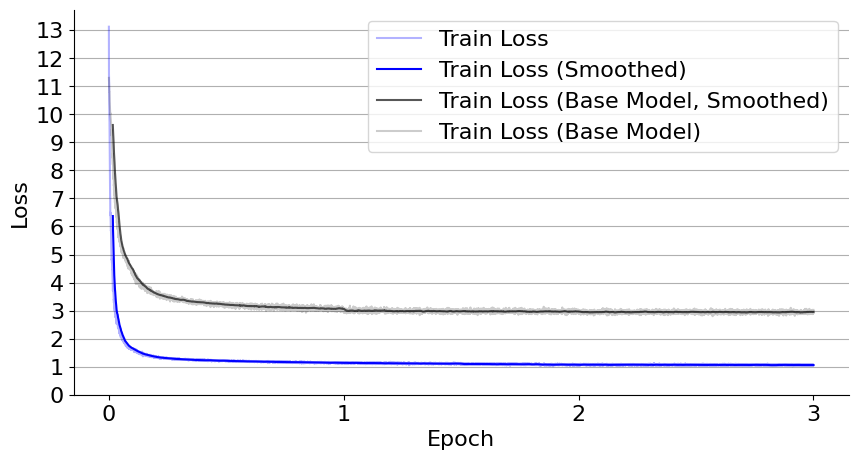

'data/models/gal_125_split_1/loss_plot_split.svg'

In [8]:
# indices to navigate the runs folder and subfolders.
run = 6 # 6 up to 50000 # 5 rest
event = 0

def convert_to_epoch(steps, epochs):
    #normalizing  to  one
    steps /= list(steps)[-1]
    # converting to epohc
    steps *= epochs
    return steps


log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[0]

# Set the font to Helvetica size 12
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16


# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() # Load the events from the file

# Extract scalar events for training and evaluation loss
train_loss_events = ea.Scalars('train/loss')
try:
    eval_loss_events = ea.Scalars('eval/loss')
except Exception: 
    print('No Eval loss found')

########## Combining two training runs
run = 5 # 6 up to 50000 # 5 rest
event = 0

log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[0]

# Set the font to Helvetica size 12
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16


# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() # Load the events from the file

# Extract scalar events for training and evaluation loss
train_loss_events_2 = ea.Scalars('train/loss')
try:
    eval_loss_events = ea.Scalars('eval/loss')
except Exception: 
    print('No Eval loss found')

train_loss_events.extend(train_loss_events_2)
print('last eval', eval_loss_events[-1])

##########
    
# Convert to DataFrame for easy manipulation
train_steps = [event.step for event in train_loss_events]
train_values = [event.value for event in train_loss_events]

try:
    eval_steps = [event.step for event in eval_loss_events]
    eval_values = [event.value for event in eval_loss_events]
except Exception: pass

train_loss_df = pd.DataFrame({'step': train_steps, 'value': train_values})
try:
    eval_loss_df = pd.DataFrame({'step': eval_steps, 'value': eval_values})
except Exception: pass
train_loss_df['step'] = convert_to_epoch(train_loss_df_base['step'], 3)
# Calculate the rolling mean for smooth curves
smoothed_train_values = train_loss_df['value'].rolling(window=50).mean()

print('last smoothed value', list(smoothed_train_values)[-1])
try:
    smoothed_eval_values = eval_loss_df['value'].rolling(window=50).mean()
except Exception: pass

# compare data from base_model
run = 0
event = 0
model_folder_base = f'data/models/gal_125_1'
log_paths_base = os.listdir(f'{model_folder_base}/runs')
log_folder_base = log_paths_base[run]
log_file_base = os.listdir(f'{model_folder_base}/runs/{log_folder_base}')[0]
ea_base = event_accumulator.EventAccumulator(f'{model_folder_base}/runs/{log_folder_base}/{log_file_base}')
ea_base.Reload() # Load the events from the file
train_loss_events_base = ea_base.Scalars('train/loss')

# Convert to DataFrame for easy manipulation
train_steps_base = [event.step for event in train_loss_events_base]
train_values_base = [event.value for event in train_loss_events_base]

train_loss_df_base = pd.DataFrame({'step': train_steps_base, 'value': train_values_base})
train_loss_df_base['step'] = convert_to_epoch(train_loss_df_base['step'], 3)
# Calculate the rolling mean for smooth curves
smoothed_train_values_base = train_loss_df_base['value'].rolling(window=50).mean()
train_values_base = train_loss_df_base['value']
#####
    
# Create the plot
plt.figure(figsize=(10,5))

# Plot the original training loss with transparency
plt.plot(train_loss_df['step'], train_loss_df['value'], alpha=0.3, color='blue', label='Train Loss')
plt.plot(train_loss_df['step'], smoothed_train_values, color='blue', label='Train Loss (Smoothed)')
plt.plot(train_loss_df_base['step'], smoothed_train_values_base, alpha=0.66, color='black', label='Train Loss (Base Model, Smoothed)')
plt.plot(train_loss_df_base['step'], train_values_base, alpha=0.2, color='black', label='Train Loss (Base Model)')


try:
    pass
    # Plot the evaluation loss in orange
    # plt.plot(eval_loss_df['step'], eval_loss_df['value'], alpha=1, color='orange', label='Eval Loss (Original)')
    #plt.plot(eval_loss_df['step'], smoothed_eval_values, color='orange', label='Eval Loss (Smoothed)')
except Exception: pass


# Set up the y-axis to show each whole number and add horizontal gridlines
try:
    plt.yticks(np.arange(int(min(train_values + eval_values)), int(max(train_values + eval_values)) + 1  , 1.0))
except Exception:
    plt.yticks(np.arange(int(min(train_values )), int(max(train_values)) + 1  , 1.0))

plt.grid(axis='y')
plt.xticks(np.arange(0, max(train_loss_df['step']) + 1, 1))

# Customize the plot to remove the box, leaving just the x and y-axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the plot as an SVG file
svg_filename = f'{model_folder}/loss_plot_split.svg'
plt.savefig(svg_filename, format='svg', bbox_inches='tight')

plt.show()

# Return the path to the saved SVG file
svg_filename

In [ ]:
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

run = 0
event = 0

log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[0]

# Matplotlib settings
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16

# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() 

# Extract text_summary
text_summary_tag = 'args/text_summary'  # or 'model_config/text_summary', depending on which you want to view
text_summary = ea.Tensors(text_summary_tag)

# Process and display the text summary
for summary in text_summary:
    tensor_proto = summary.tensor_proto
    tensor = tf.make_ndarray(tensor_proto)
    text_data = tensor.item().decode('utf-8')
    print(text_data)

## t-SNE

In [ ]:
context_less = False
###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available
             
model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loadede Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/themes_descriptions.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/viewpoints_descriptions.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/numbers_descriptions.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
        full_descriptions_dict = pk.load(f)

###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()


#Embeddings if the model is not a sequence classification model
out_emb = model.get_output_embeddings()
out_emb = next(out_emb.parameters()).to('cpu').detach().numpy()[2:]
inp_emb = inp_emb(torch.arange(len(tokenizer))).to('cpu').detach().numpy()[50002:]

if context_less:
    # Extracting context less embeddings
    if not os.path.isfile(f'{model_folder}/context_less_emb.pk'):
        print('Calculating context less embeddings!')
        context_less_emb = [[] for _ in range(13)]
        for i in range(len(tokenizer)):
            print(i, end='\r')
            out = model(input_ids= torch.tensor([[i]]), attention_mask = torch.tensor([[1]]), output_hidden_states=True)
                
            out = out.hidden_states
            for i, k in enumerate(out):
                context_less_emb[i].append(k.to('cpu').detach().numpy())
        with open(f'{model_folder}/context_less_emb.pk', 'wb') as f:
            pk.dump(context_less_emb, f)
    else:
        print('Loading context less embeddings from disk')
        with open(f'{model_folder}/context_less_emb.pk', 'rb') as f:
            context_less_emb = pk.load(f)
        
    # Combining context less embeddings of a layer to a single tensor
    for i, layer in enumerate(context_less_emb):
        layer = [e[0] for e in layer]
        layer = np.concatenate(layer, 0)
        context_less_emb[i] = layer


    

## Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)
if context_less:
    context_less_emb = [normalize(layer) for layer in context_less_emb]

# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

# Creating  a dict with f-Terms and their embedding vectors:

out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}
inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}

if context_less:
    # Creating Context Less Embedding Dicts
    context_less_dicts = []
    for layer in context_less_emb:
        context_less_dicts.append({token[:-1]: vec for token, vec in zip(tokens, layer)})

In [ ]:
# Calculating the TSNE Representation of all output embeddigns
if os.path.isfile(f'{model_folder}/output_tsne_rep_{checkpoint}.pk'):
    print('loading TSNE Representation from disk!')
    with open(f'{model_folder}/output_emb_tsne_numbers{checkpoint}.pk', 'rb') as f:
        out_tsne = pk.load(f)
else:
    print('Calculating TSNE Representation (takes up to an hour)')
    tsne = TSNE(n_components=2, verbose=0, random_state=69) 
    tsne_rep = tsne.fit_transform(out_emb)
    with open(f'{model_folder}/output_emb_tsne_{checkpoint}.pk', 'wb') as f:
        pk.dump(tsne_rep, f)
    out_tsne = tsne_rep

#removing theme and viewpoint tokens
tokens_2 = []
rep = []
themes = []


for i,  token in enumerate(f_term_tokens):
    #r = out_tsne[i]
    if len(token) < 10: continue
    themes.append(token[:8])
    tokens_2.append(token)
    #rep.append(r)

tokens = tokens_2
#out_tsne = np.stack(rep)



In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


with open(f'{model_folder}/themes.pk', 'wb') as f:
    pk.dump(themes, f)

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(out_tsne[:, 0], out_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/out_tsne_split.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

themes = [t[:5] for t in tokens[50002:]]
print(len(themes))

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(inp_tsne[:, 0], inp_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/inp_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

## Histograms

In [ ]:
seq_class = False
###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available

if seq_class:
    model = OPTForSequenceClassification.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)
else:
    model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/themes_descriptions.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/viewpoints_descriptions.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/numbers_descriptions.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)


###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()

if not seq_class:
    #Embeddings if the model is not a sequence classification model
    out_emb = model.get_output_embeddings()
    out_emb = next(out_emb.parameters()).to('cpu').detach().numpy()[2:]
    inp_emb = inp_emb(torch.arange(len(tokenizer))).to('cpu').detach().numpy()[50002:]
    


## Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)


# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = []
out_emb_2 = []

for i, token in enumerate(tokens[50002:]):
    if len(token) < 10: continue
    out_emb_2.append(out_emb[i])
    f_term_tokens.append(token)

out_emb = np.stack(out_emb_2)

# Creating  a dict with f-Terms and their embedding vectors:

out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}
if seq_class:
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(tokens[:50000], inp_emb)}
else: 
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}
    



####################################################
# Detecting F-Term Pairs with Supposed Similarities
####################################################
df=pd.read_csv("data/f-terms.csv", index_col=0)

#subset with "material" in the viewpoint description
df2=df[df.viewpoint_label.str.contains("material",case=False, na=False)].copy()
df2["vp"]=df2.theme+"/"+df2.viewpoint
df2["fterm"]=df2.theme+"/"+df2.number

#f-term descriptions are searched for the following materials
materials_list=["metal", "wood", "concrete", "resin", "fiber", "wool", "sand", "cord", "copper", "iron", "silver", "gold", "lead", "glass", "stone", "titanium", "steel", "cement", "silicon", "polymer", "ceramics"]
materials_f_terms={}
for material in materials_list:
    materials_f_terms[material]=[df2[df2.label.str.contains(material,case=False, na=False)].vp.unique(), df2[df2.label.str.contains(material,case=False, na=False)].fterm.values]

#pairs of two materials with fterms in same viewpoints are created
material_combinations={}
for mat1 in materials_list:
    for mat2 in materials_list:
        
        if mat1==mat2: continue
        if mat2+"_"+mat1 in materials_f_terms: continue
        
        #filtering shared f-terms with both materials in the label description
        
        unique_fterms_mat1 = list(set(materials_f_terms[mat1][1]) - set(materials_f_terms[mat2][1]))
        unique_fterms_mat2 = list(set(materials_f_terms[mat2][1]) - set(materials_f_terms[mat1][1]))


        vp_mat1= set([x[:8]for x in unique_fterms_mat1])
        vp_mat2= set([x[:8]for x in unique_fterms_mat2])
        shared_vp=[x for x in vp_mat1 if x in vp_mat2]
        fterm_pairs=[]
        for vp in shared_vp:
            fterm_pairs.append([vp,
                                [fterm for fterm in unique_fterms_mat1 if fterm.startswith(vp)][:1],
                                [fterm for fterm in unique_fterms_mat2 if fterm.startswith(vp)][:1]])
            
            
        material_combinations[mat1+"_"+mat2]=fterm_pairs

# material_combinations contains material combinations in both directions

In [ ]:
# Redoo the out of com similariteis

In [ ]:
emb = out_emb_dict
#layer_n = 13
#emb = context_less_dicts[layer_n]
# Dictionary that contains all differences and additional information for each material combination
differences = {}
# Huge dict, that contains the difference vectors as keys and 
diffs_dict = {}

for i, combination in enumerate(material_combinations.items()):
    key, item = combination
    print(i, key, end='\r')
    # Checking if the reverse combination was already calculated
    # Thank god i thought of that, i was so panicing, that i was comparing vectors in both direcitions int hte out of comb similarities
    current_material_keys = []
    for current_key in differences.keys():
        current_material_keys.append(current_key.split('_'))
    combination_keys = key.split('_')
    combination_keys.reverse()
    if combination_keys in current_material_keys:
        continue

    # Calculating the differences and storing them in a list of dict
    combinations_list = []
    for viewpoint_comb in item:
        viewpoint, mat_1, mat_2 = viewpoint_comb
        for f_term_1 in mat_1:
            for f_term_2 in mat_2:
                try: 
                    vec_1 = emb[f_term_1]
                    vec_2 = emb[f_term_2]
                    diff = vec_2 - vec_1
                    diff = normalize(np.array([diff]))[0]                   
                    sample_dict = {}
                    sample_dict['Vector'] = diff
                    sample_dict['Viewpoint'] = viewpoint
                    sample_dict['F-Term 1'] = f_term_1
                    sample_dict['F-Term 2'] = f_term_2
                    diffs_dict[sys.intern(str(np.sum(diff)))] = [viewpoint, f_term_1, f_term_2]
                    combinations_list.append(sample_dict)
                except KeyError:
                    continue
    # Now the differences are computed and stored in a list of dicts
    differences[key] = combinations_list         


# Pairing the vectors to compare

max_comb = 100000000
sqr_max_comb = int(max_comb**0.5)
in_combination_comparisons = {}

for i, [keys, samples] in enumerate(differences.items()):
    # Adding the comparison of the material combination with itself to the comparisons
    in_combination_comparisons[keys] = {'Vectors A': [], 
                                        'Vectors B': [],
                                        'Viewpoints': [],
                                        'F-Terms A': [],
                                        'F-Terms B': []}
    print(i, keys, len(samples), end = '\r')
    samples_2 = list(samples)
    random.shuffle(samples_2)
    s1 = 0 
    while len(samples_2) > 0:
        s1 += 1
        s2 = 0
        sample_a = samples_2.pop(0)
        random.shuffle(samples_2)
        for sample_b in samples_2:

            if s2 == sqr_max_comb:
                break
            # Ignoring combinations with matching Viewpoints
            if sample_a['Viewpoint'] == sample_b['Viewpoint']:
                continue
            # Debugging remove later 
            ##################################
            vpa = sample_a['Viewpoint']
            vpb = sample_b['Viewpoint']
            theme_a = vpa.split('/')[0]
            theme_b = vpb.split('/')[0]
            if theme_a == theme_b:
                continue
            ###################################
            in_combination_comparisons[keys]['Vectors A'].append(torch.tensor(np.array([sample_a['Vector']])))
            in_combination_comparisons[keys]['Vectors B'].append(torch.tensor(np.array([sample_b['Vector']])))
            in_combination_comparisons[keys]['Viewpoints'].append([sample_a['Viewpoint'], sample_a['Viewpoint']])
            in_combination_comparisons[keys]['F-Terms A'].append([sample_a['F-Term 1'], sample_a['F-Term 2']])
            in_combination_comparisons[keys]['F-Terms B'].append([sample_b['F-Term 1'], sample_b['F-Term 2']])
            s2 += 1
        if s1 == sqr_max_comb:
            break

            
# Calculating the Cosine Similarities within all combinations
cos = torch.nn.CosineSimilarity(dim =1)
bad_keys = []
min_comb = 2000

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    print(' '*1000, end='\r')
    print(i, key, end = '\r')
    try:
        similarities = cos(torch.cat(combination_dict['Vectors A'], 0), torch.cat(combination_dict['Vectors B'], 0))
        # Dropping combinations with low sample counts
        if len(similarities) < min_comb:
            print('Low number of samples in:', key, len(similarities), end='\r')
            bad_keys.append(key)
            continue
        combination_dict['Cosine Similarities'] = np.array(similarities)
        # Creating a sorted index of the similariteis to compare the best ones with other combinations
        combination_dict['Sort idx'] = np.argsort(np.array(similarities))[::-1]
        
        
    except RuntimeError:
        print(' '*1000, end='\r')
        print('Empty combination dictionary found, dropping  it!', key, end='\r')
        bad_keys.append(key)
        continue
        

for key in bad_keys:
    in_combination_comparisons.pop(key)

    
# Extracting the best vectors 
for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    top_100 = np.array(combination_dict['Cosine Similarities'])
    idx = combination_dict['Sort idx'][:100]
    top_100 = top_100[idx]
    # Top 100 vectors a
    top_vectors = np.concatenate(combination_dict['Vectors A'], 0)[idx]
    top_vectors = np.concatenate([np.concatenate(combination_dict['Vectors B'], 0)[idx], top_vectors])
    # dropping duplicates
    top_vectors = np.unique(top_vectors, axis = 0)    
    combination_dict['Best Vectors']  = top_vectors
    print(' '*1000, end='\r')
    print(i, key, len(top_vectors), end='\r')  


# Computing the cosine similarities for out of combination comparisons

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    #print(' '*1000, end='\r')
    #print(i, key, end=' \r')
    #print(i, key)
    
    # Extracting all unique vectors from other material combinations, which do not share a material with the material 
    # Combination to be checked
    all_vectors = []
    material_1, material_2 = key.split('_')
    for key2, samples in differences.items():
        
        materials2 = key2.split('_')
        # Ignoring material combinations with matching materials 
        if material_1 in materials2 or material_2 in materials2:
            continue
        # Ignoring material combinations which do not appear in the in_combination_comparisons keys
        if not key2 in [k for k in in_combination_comparisons.keys()]:
            continue
        
        for sample_dict in samples:
            all_vectors.append(sample_dict['Vector'])
            
    
    all_vectors = np.stack(all_vectors, 0)
    # removing duplicate vectors just to be sure
    all_vectors = np.unique(all_vectors, axis=0)
    np.random.shuffle(all_vectors)
    
    l = len(combination_dict['Cosine Similarities'])
    vectors_a , vectors_b = [], []
    top_vectors = list(combination_dict['Vectors A'])
    top_vectors.extend(combination_dict['Vectors B'])
    
    top_vectors = np.concatenate(top_vectors, 0)

    np.random.shuffle(top_vectors)
   

    for top_vector in top_vectors:
        vp, _ ,_ = diffs_dict[str(np.sum(top_vector))]
        if len(vectors_a) == l: 
            break
        for vector in all_vectors:
            if len(vectors_a) == l: 
                break
            vp2, _, _ = diffs_dict[str(np.sum(vector))]
            # Skipping vectors with the same viewpoints
            if vp2 == vp:
                continue
            ##### Debugging remove later
            theme_a = vp.split('/')[0]
            theme_b = vp2.split('/')[0]
            if theme_a == theme_b:
                continue
            #############################
            vectors_a.append(top_vector)
            vectors_b.append(vector)
            
    
    vectors_a = np.stack(vectors_a, 0)
    vectors_b = np.stack(vectors_b, 0)
   
    similarities = cos(torch.tensor(vectors_a), torch.tensor(vectors_b)).numpy()
    combination_dict['Out of Comb Simis'] = similarities



In [ ]:
# Set the font to Helvetica size 12
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16


layer_n = f'Just one sample per viewpoint {vectors_a[0].shape}'
# Plotting all out of comb similarities vs all in comb similarities (combined)
all_in_comb = []
all_out_comb = []
for comb_dict in in_combination_comparisons.values():
    all_in_comb.extend(comb_dict['Cosine Similarities'])
    all_out_comb.extend(comb_dict['Out of Comb Simis'])

all_in_comb = np.array(all_in_comb)
all_out_comb = np.array(all_out_comb)
mean_in = np.mean(all_in_comb)
mean_out = np.mean(all_out_comb)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])

np.random.shuffle(all_out_comb)
axs.hist(all_in_comb, bins=100, alpha=0.75, label='Equal Material Combinations')
axs.hist(all_out_comb[-len(all_in_comb):], bins=100, alpha=0.75, label='Control Group')

axs.set_xlabel('Cosine Similarity', labelpad=15)
axs.set_ylabel('Frequency', labelpad=15)
axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), frameon=False)

# Remove the spines (borders)
for spine in axs.spines.values():
    spine.set_visible(False)

# Save the figure as an SVG file in the specified model folder
fig.savefig(f'{model_folder}/material_comb_hist.svg', format='svg')
print(mean_in, 'mean_in', mean_out, 'meany_out')
plt.show()


In [ ]:
layer_n = f'Just one sample per viewpoint {vectors_a[0].shape}'
# Plotting all out of comb similarities vs all in comb similarities (combined)
all_in_comb = []
all_out_comb = []
for comb_dict in in_combination_comparisons.values():
    all_in_comb.extend(comb_dict['Cosine Similarities'])
    all_out_comb.extend(comb_dict['Out of Comb Simis'])

all_in_comb = np.array(all_in_comb)
all_out_comb = np.array(all_out_comb)
mean_in = np.mean(all_in_comb)
mean_out = np.mean(all_out_comb)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])

#np.random.shuffle(all_out_comb)
axs.hist(all_in_comb, bins=100, alpha=0.75, label='Equivaltent Material Combinations')
axs.hist(all_out_comb[-len(all_in_comb):], bins=100, alpha=0.75, label='Random Material Combinations')
axs.axvline(mean_in , color='red', linestyle='dashed', linewidth=1)
axs.axvline(mean_out, color='magenta', linestyle='dashed', linewidth=1)
#axs.text(mean_in + 0.01, axs.get_ylim()[1] * 0.9, f'Mean: {mean_in:.6f}', color='grey')
#axs.text(mean_in + 0.01, axs.get_ylim()[1] * 0.925, f'Out of Comb Mean: {mean_out:.6f}', color='grey')
# Setting the titles for the x and y axes
axs.set_xlabel('Cosine Similarity')
axs.set_ylabel('Frequency')
axs.legend()

# Remove the spines (borders)
for spine in axs.spines.values():
    spine.set_visible(False)

# Save the figure as an SVG file in the specified model folder
fig.savefig(f'{model_folder}/material_comb_hist.svg', format='svg')

print(mean_in, 'mean_in', mean_out, 'meany_out')


plt.show()





## Loss Curve

In [ ]:
# indices to navigate the runs folder and subfolders.
run = 0
event = 0

log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[0]

# Set the font to Helvetica size 12
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16


# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() # Load the events from the file

# Extract scalar events for training and evaluation loss
train_loss_events = ea.Scalars('train/loss')
try:
    eval_loss_events = ea.Scalars('eval/loss')
except Exception: 
    print('No Eval loss found')

# Convert to DataFrame for easy manipulation
train_steps = [event.step for event in train_loss_events]
train_values = [event.value for event in train_loss_events]
try:
    eval_steps = [event.step for event in eval_loss_events]
    eval_values = [event.value for event in eval_loss_events]
except Exception: pass

train_loss_df = pd.DataFrame({'step': train_steps, 'value': train_values})
try:
    eval_loss_df = pd.DataFrame({'step': eval_steps, 'value': eval_values})
except Exception: pass

# Calculate the rolling mean for smooth curves
smoothed_train_values = train_loss_df['value'].rolling(window=50).mean()
try:
    smoothed_eval_values = eval_loss_df['value'].rolling(window=50).mean()
except Exception: pass

# Create the plot
plt.figure(figsize=(10,5))

# Plot the original training loss with transparency
plt.plot(train_loss_df['step'], train_loss_df['value'], alpha=0.3, color='blue', label='Train Loss (Original)')
plt.plot(train_loss_df['step'], smoothed_train_values, color='blue', label='Train Loss (Smoothed)')

try:
    # Plot the evaluation loss in orange
    plt.plot(eval_loss_df['step'], eval_loss_df['value'], alpha=1, color='orange', label='Eval Loss (Original)')
    #plt.plot(eval_loss_df['step'], smoothed_eval_values, color='orange', label='Eval Loss (Smoothed)')
except Exception: pass


# Set up the y-axis to show each whole number and add horizontal gridlines
try:
    plt.yticks(np.arange(int(min(train_values + eval_values)), int(max(train_values + eval_values)) + 1  , 1.0))
except Exception:
    plt.yticks(np.arange(int(min(train_values )), int(max(train_values)) + 1  , 1.0))

plt.grid(axis='y')

# Customize the plot to remove the box, leaving just the x and y-axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.title('')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

# Save the plot as an SVG file
svg_filename = f'{model_folder}/loss_plot_1.svg'
plt.savefig(svg_filename, format='svg', bbox_inches='tight')

plt.show()

# Return the path to the saved SVG file
svg_filename

In [ ]:
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

run = 0
event = 0

log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[0]

# Matplotlib settings
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16

# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() 

# Extract text_summary
text_summary_tag = 'args/text_summary'  # or 'model_config/text_summary', depending on which you want to view
text_summary = ea.Tensors(text_summary_tag)

# Process and display the text summary
for summary in text_summary:
    tensor_proto = summary.tensor_proto
    tensor = tf.make_ndarray(tensor_proto)
    text_data = tensor.item().decode('utf-8')
    print(text_data)

# !!! Agg model small !!!

In [ ]:
# Imports

# Own Packages
from Masterarbeit_utils.model_utils_agg import get_tokenizer, load_and_modify_model, load_pretrained_Tokenizer

# Site-Packages
import dask.dataframe as dd
import torch
import psutil
import os
import sys
import pickle as pk
import pandas as pd
import numpy as np
import bokeh
import time
import random
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from cProfile import Profile
from pstats import SortKey, Stats

# Dimension reduction algorithms
#from cuml.manifold import TSNE
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import export_png

from transformers import AutoTokenizer, OPTForCausalLM
from tokenizers.processors import TemplateProcessing
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset
from tensorboard.backend.event_processing import event_accumulator

%matplotlib inline
output_notebook()
# Model config
"""
The Paths to important folders have to be changed for your system.
"""

# Name of this experiment
model_name = 'gal_125_agg_aug_1'
checkpoint =100000
# If True normalization is applied to the embeddings
norm = True


# This folder will be created and filled with txt files for each sample after you run the Pytorch Dataset Notebook
dataset_folder = f'data/agg_dataset_samples'

# The folder at which the model will be saved. This folder has to be created for your system 
model_folder = f'data/models/{model_name}'
os.makedirs(model_folder, exist_ok=True)


# Folder in which the tokenizer will be saved
tokenizer_folder = f'data/tokenizers/{model_name}'
os.makedirs(tokenizer_folder, exist_ok=True)

# Folder at which all pickle files are stored. This folder is fixed for this project and should not be changed
dump_dir = r'PK_DUMP'

# Model parameters 
'''
mini	125 M
base	1.3 B
standard	6.7 B
large	30 B
huge	120 B'''
base_model_name = 'mini'

# All new Torch-objects will be by default in this dtype
# if default_type = float16 fp16 must be False
default_dtype = torch.float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_default_dtype(default_dtype)

# Default device on which the model will be loaded
#default_device = 'cuda:0'
default_device = 'cpu'
# Number of GPUs the model will be parallelised to 
num_gpus = 1
# If you change 'default_device' to 'cpu', make sure to set num_gpus to zero.
if default_device == 'cpu':
    num_gpus = 0

tensor_parallel = False



## Loss Curve

In [ ]:
# indices to navigate the runs folder and subfolders.

run = 0
event = 1

log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[event]

# Set the font
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16


def convert_to_epoch(steps, epochs):
    #normalizing  to  one
    steps /= list(steps)[-1]
    # converting to epohc
    steps *= epochs
    return steps

# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() # Load the events from the file
print(ea.Tags())


# Extract scalar events for training and evaluation loss
train_loss_events = ea.Scalars('train/loss')
try:
    eval_loss_events = ea.Scalars('eval/loss')
    print('last eval', eval_loss_events[-1])
except Exception: 
    print('No Eval loss found')
    

# Convert to DataFrame for easy manipulation
train_steps = [event.step for event in train_loss_events]
train_values = [event.value for event in train_loss_events]

train_loss_df = pd.DataFrame({'step': train_steps, 'value': train_values})
train_loss_df['step'] = convert_to_epoch(train_loss_df['step'], 3)

# Calculate the rolling mean for smooth curves
smoothed_train_values = train_loss_df['value'].rolling(window=50).mean()


# compare data from base_model
run = 0
event = 0
model_folder_base = f'data/models/gal_125_1'
log_paths_base = os.listdir(f'{model_folder_base}/runs')
log_folder_base = log_paths_base[run]
log_file_base = os.listdir(f'{model_folder_base}/runs/{log_folder_base}')[0]
ea_base = event_accumulator.EventAccumulator(f'{model_folder_base}/runs/{log_folder_base}/{log_file_base}')
ea_base.Reload() # Load the events from the file
train_loss_events_base = ea_base.Scalars('train/loss')

# Convert to DataFrame for easy manipulation
train_steps_base = [event.step for event in train_loss_events_base]
train_values_base = [event.value for event in train_loss_events_base]

train_loss_df_base = pd.DataFrame({'step': train_steps_base, 'value': train_values_base})
train_loss_df_base['step'] = convert_to_epoch(train_loss_df_base['step'], 3)
# Calculate the rolling mean for smooth curves
smoothed_train_values_base = train_loss_df_base['value'].rolling(window=50).mean()
#####

# compare data from large_model
run = 0
event = 0
model_folder_l = f'data/models/gal_1300_agg_aug_1'
log_paths_l = os.listdir(f'{model_folder_l}/runs')
log_folder_l = log_paths_l[run]
log_file_l = os.listdir(f'{model_folder_l}/runs/{log_folder_l}')[0]
ea_l = event_accumulator.EventAccumulator(f'{model_folder_l}/runs/{log_folder_l}/{log_file_l}')
ea_l.Reload() # Load the events from the file
train_loss_events_l = ea_l.Scalars('train/loss')

# Convert to DataFrame for easy manipulation
train_steps_l = [event.step for event in train_loss_events_l][500:]
train_values_l = [event.value for event in train_loss_events_l][500:]

train_loss_df_l = pd.DataFrame({'step': train_steps_l, 'value': train_values_l})
train_loss_df_l['step'] = convert_to_epoch(train_loss_df_l['step'], 1)
# Calculate the rolling mean for smooth curves
smoothed_train_values_l = train_loss_df_l['value'].rolling(window=50).mean()
#####




print('last smoothed value', list(smoothed_train_values)[-1])
    
# Create the plot
plt.figure(figsize=(10,5))

# Plot the original training loss with transparency
plt.plot(train_loss_df['step'], train_loss_df['value'], alpha=0.3, color='blue', label='Train Loss (Original)')
plt.plot(train_loss_df['step'], smoothed_train_values, color='blue', label='Train Loss (Smoothed)')
plt.plot(train_loss_df_l['step'], train_loss_df_l['value'], alpha=0.3, color='orange', label='Train Loss (1.3B Model)')
plt.plot(train_loss_df_l['step'], smoothed_train_values_l, color='orange', label='Train Loss (1.3B Model, Smoothed)')
plt.plot(train_loss_df_base['step'], smoothed_train_values_base, color='black', label='Train Loss (Base Model, Smoothed)')



# Set up the y-axis to show each whole number and add horizontal gridlines
try:
    plt.yticks(np.arange(int(min(train_values + eval_values + train_values_base )), int(max(train_values + eval_values + train_values_base)) + 1  , 1.0))
except Exception:
    plt.yticks(np.arange(int(min(train_values )), int(max(train_values)) + 1  , 1.0))

plt.grid(axis='y')

# Customize the plot to remove the box, leaving just the x and y-axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(np.arange(0, max(train_loss_df['step']) + 1, 1))

#plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the plot as an SVG file
svg_filename = f'{model_folder}/loss_plot_aug.svg'
plt.savefig(svg_filename, format='svg', bbox_inches='tight')

plt.show()

# Return the path to the saved SVG file
svg_filename

In [ ]:
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

run = 0
event = 0

log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[0]

# Matplotlib settings
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16

# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() 

# Extract text_summary
text_summary_tag = 'args/text_summary'  # or 'model_config/text_summary', depending on which you want to view
text_summary = ea.Tensors(text_summary_tag)

# Process and display the text summary
for summary in text_summary:
    tensor_proto = summary.tensor_proto
    tensor = tf.make_ndarray(tensor_proto)
    text_data = tensor.item().decode('utf-8')
    print(text_data)

In [ ]:
# Loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')

# Loading the model
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
         _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available


model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                           device_map=device_map, max_memory=max_memory)

# Loading the dataset
class JapPatDataset(Dataset):
    """Dataset containing Japanese patents and their F-Term classification"""
    def __init__(self, data_folder, tokenizer):
        """
        data_folder: path to folder containing the text samples
        tokenizer: tokenizer instance with added additional Tokens for F-Terms
        """
        super(Dataset).__init__()
        self.data_folder = data_folder
        # This has to be manually set to the ammount of files in the 'dataset_samples' folder. Calculating the number of files in this folder would take forever.
        # A to low number would lead to samples missing from the dataset.
        # A to high number would raise a FileNotFound error.
        self.l = len(os.listdir(data_folder)) - 1
        #self.l = 10000
        self.tokenizer = tokenizer
        
    def __len__(self):
        return self.l
    
    def __getitem__(self, idx):
        try:
            with open(f'{self.data_folder}/{idx}.txt', 'r', encoding='utf-8') as f:
                item = f.read()
        except FileNotFoundError:
            
            raise FileNotFoundError
        
        # Tokenizing the item 
        # The Tokenizer will return a dict with the encoded text as 'input_ids', 
        # a mask which shows the tokens types this will not be needed for our applications
        # and a mask for the attention mechanism as 'attention_mask' The attention mask will be needed to indicate, that the 
        # model should not attend to <pad> tokens.
        
        output = self.tokenizer(item)  
        output.pop('token_type_ids')
        return output


train_dataset = JapPatDataset(f'{dataset_folder}/train', tokenizer)
validation_dataset = JapPatDataset(f'{dataset_folder}/validation', tokenizer)

# Loading a dict that contains the definitions of the f-terms
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)

In [ ]:
def classic_accurracy(batch, model, top_k=1):
    """
    Classic prediction accuracy metric. 
    This function should be applied to a batch of samples,
    which were tokenized by a tokenizer instance.
    This function returns the procentual accuracy metric as well as the total number of correct predictions
    and the total number of predictions in this batch

    :batch: batch of samples from validation dataset
    :model: model which should be testet
    :top_k: top k predictions which should be investigated for a correct result.
    """
    with torch.no_grad():
        model.eval()
        logits = model(**batch, output_hidden_states=False, return_dict=True)['logits']

    input_ids = batch['input_ids']
    # Removing first label
    labels = input_ids[:, 1:]
    # removing last prediction
    logits = logits[:, :-1]
    # Sorting the logits to get the predictions orderd from highest to lowest
    _, preds = torch.sort(logits, dim=-1, descending=True)
    # Dropping all text predictions and labels, keeping just the predictions and labels for f-terms
    token_threshold = 50000 # tokens with an ids_value below the token_threshold are removed
    preds = preds[labels > token_threshold]
    # only taking the top k predictions:
    preds = preds[:,:top_k]
    # the predictions are missing the 50000 text tokens so the predictions have to be increased by 50000
    preds += 50000
    labels = labels[labels > token_threshold]
    n_preds = labels.shape[0] # number of values that are to be predicted

    # expanding the labels to the same size as the predictions
    labels = labels.unsqueeze(dim=-1)
    labels = labels.expand(-1, top_k)
    n_correct = len(labels[labels == preds])
    accuracy = 100*n_correct/n_preds
    return accuracy, n_correct, n_preds
    

class Batch_DataLoader():
    """
    This class converts a dataset to a iterable dataloader, which loads padded patches of data.   
    """
    def __init__(self,
                 dataset, 
                 batchsize=10,
                 datacollator=DataCollatorWithPadding(tokenizer, return_tensors='pt')):

        self.dataset = dataset
        self.batchsize = batchsize
        self.l = len(dataset)//batchsize + 1
        self.datacollator = datacollator
        self.current = 0

    def __len__(self):
        return self.l

    def __iter__(self):
        self.current = 0
        return self

    def __next__(self):
        batch = [self.dataset[i] for i in range(self.current, self.current+self.batchsize)]
        batch = self.datacollator(batch)
        self.current += self.batchsize
        return batch
        

def accuracy_on_dataset(dataset, model, top_k=1, batch_size=10, batches = 20):
    loader = Batch_DataLoader(dataset, batch_size)
    n_pred = 0
    n_corr = 0
    for i, batch in enumerate(loader):
        if i == batches: break
        acc, corr, pred = classic_accurracy(batch, model, top_k)
        n_pred += pred
        n_corr += corr
        print(f'batch_acc: {acc:.2f}%, total_acc: {100*n_corr/n_pred:.2f}% batch {i}/{len(loader)}', end ='\r')
    
    return n_pred, n_corr
    



In [ ]:
n_pred, n_corr = accuracy_on_dataset(validation_dataset, model, top_k=1, batch_size=50, batches = 20)

In [ ]:
n_pred, n_corr = accuracy_on_dataset(validation_dataset, model, top_k=5, batch_size=50, batches = 20)

## t-SNE 

In [ ]:
context_less = False
###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available
             
model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loadede Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/themes_descriptions.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/viewpoints_descriptions.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/numbers_descriptions.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
        full_descriptions_dict = pk.load(f)

###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()


#Embeddings if the model is not a sequence classification model
out_emb = model.get_output_embeddings()
out_emb = next(out_emb.parameters()).to('cpu').detach().numpy()[2:]
inp_emb = inp_emb(torch.arange(len(tokenizer))).to('cpu').detach().numpy()[50002:]

if context_less:
    # Extracting context less embeddings
    if not os.path.isfile(f'{model_folder}/context_less_emb.pk'):
        print('Calculating context less embeddings!')
        context_less_emb = [[] for _ in range(13)]
        for i in range(len(tokenizer)):
            print(i, end='\r')
            out = model(input_ids= torch.tensor([[i]]), attention_mask = torch.tensor([[1]]), output_hidden_states=True)
                
            out = out.hidden_states
            for i, k in enumerate(out):
                context_less_emb[i].append(k.to('cpu').detach().numpy())
        with open(f'{model_folder}/context_less_emb.pk', 'wb') as f:
            pk.dump(context_less_emb, f)
    else:
        print('Loading context less embeddings from disk')
        with open(f'{model_folder}/context_less_emb.pk', 'rb') as f:
            context_less_emb = pk.load(f)
        
    # Combining context less embeddings of a layer to a single tensor
    for i, layer in enumerate(context_less_emb):
        layer = [e[0] for e in layer]
        layer = np.concatenate(layer, 0)
        context_less_emb[i] = layer


    

## Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)
if context_less:
    context_less_emb = [normalize(layer) for layer in context_less_emb]

# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

# Creating  a dict with f-Terms and their embedding vectors:

out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}
inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}

if context_less:
    # Creating Context Less Embedding Dicts
    context_less_dicts = []
    for layer in context_less_emb:
        context_less_dicts.append({token[:-1]: vec for token, vec in zip(tokens, layer)})

In [ ]:
# Calculating the TSNE Representation of all output embeddigns
if os.path.isfile(f'{model_folder}/output_emb_tsne_{checkpoint}.pk'):
    print('loading TSNE Representation from disk!')
    with open(f'{model_folder}/output_emb_tsne_{checkpoint}.pk', 'rb') as f:
        out_tsne = pk.load(f)
else:
    print('Calculating TSNE Representation (takes up to an hour)')
    tsne = TSNE(n_components=2, verbose=0, random_state=69) 
    tsne_rep = tsne.fit_transform(out_emb)
    with open(f'{model_folder}/output_emb_tsne_{checkpoint}.pk', 'wb') as f:
        pk.dump(tsne_rep, f)
    out_tsne = tsne_rep



In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

themes = [t[:5] for t in tokens[50002:]]
print(len(themes))

with open(f'{model_folder}/themes.pk', 'wb') as f:
    pk.dump(themes, f)

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(out_tsne[:, 0], out_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/out_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

themes = [t[:5] for t in tokens[50002:]]
print(len(themes))

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(inp_tsne[:, 0], inp_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/inp_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

last_layer_tnse = layer_tsne_reps[0][50000:]
inp_tsne = inp_tsne[50000:]

themes = [t[:5] for t in tokens[50000:]]

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(last_layer_tsne[:, 0], last_layer_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/last_layer_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

## Histograms

In [ ]:
"""
The Paths to important folders have to be changed for your system.
"""

# Name of this experiment
model_name = 'gal_1300_agg_aug_1'
checkpoint = 83438
# If True normalization is applied to the embeddings
norm = True
seq_class = False
context_less = False

if seq_class:
    # Importing code for sequence classification
    from Masterarbeit_utils.model_utils_seq_class import get_tokenizer, load_and_modify_model, load_pretrained_Tokenizer
    from transformers import OPTForSequenceClassification

# This folder will be created and filled with txt.files for each sample after you run the Pytorch Dataset Notebook
dataset_folder = f'data/agg_dataset_samples'

# The folder at which the model will be saved. This folder has to be created for your system 
model_folder = f'data/models/{model_name}'
os.makedirs(model_folder, exist_ok=True)


# Folder in which the tokenizer will be saved
tokenizer_folder = f'data/tokenizers/{model_name}'
os.makedirs(tokenizer_folder, exist_ok=True)

# Folder at which all pickle files are stored. This folder is fixed for this project and should not be changed
dump_dir = r'PK_DUMP'

# Model parameters 
'''
mini	125 M
base	1.3 B
standard	6.7 B
large	30 B
huge	120 B'''
base_model_name = 'mini'

# All new Torch-objects will be by default in this dtype
# if default_type = float16 fp16 must be False
default_dtype = torch.float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_default_dtype(default_dtype)

# Default device on which the model will be loaded
default_device = 'cpu'

# Number of GPUs the model will be parallelised to 
num_gpus = 1
# If you change 'default_device' to 'cpu', make sure to set num_gpus to zero.
if default_device == 'cpu':
    num_gpus = 0

tensor_parallel = False


###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available

if seq_class:
    model = OPTForSequenceClassification.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)
else:
    model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/agg_themes_descriptions.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/agg_viewpoints_descriptions.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/agg_numbers_descriptions.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/agg_full_descriptions.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)


###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()

if not seq_class:
    #Embeddings if the model is not a sequence classification model
    out_emb = model.get_output_embeddings()
    out_emb = next(out_emb.parameters()).to('cpu').detach().numpy()[2:]
    inp_emb = inp_emb(torch.arange(len(tokenizer))).to('cpu').detach().numpy()[50002:]

    if context_less:
        # Extracting context less embeddings
        if not os.path.isfile(f'{model_folder}/context_less_emb{checkpoint}.pk'):
            print('Calculating context less embeddings!')
            context_less_emb = [[] for _ in range(len([1 for _ in model.parameters()]))]
            for i in range(len(tokenizer)):
                print(i, end='\r')
                out = model(input_ids= torch.tensor([[i]]), attention_mask = torch.tensor([[1]]), output_hidden_states=True)
                
                out = out.hidden_states
                for i, k in enumerate(out):
                    context_less_emb[i].append(k.to('cpu').detach().numpy())
            with open(f'{model_folder}/context_less_emb{checkpoint}.pk', 'wb') as f:
                pk.dump(context_less_emb, f)
        else:
            print('Loading context less embeddings from disk')
            with open(f'{model_folder}/context_less_emb{checkpoint}.pk', 'rb') as f:
                context_less_emb = pk.load(f)
        
        # Combining context less embeddings of a layer to a single tensor
        for i, layer in enumerate(context_less_emb):
            layer = [e[0] for e in layer]
            layer = np.concatenate(layer, 0)
            context_less_emb[i] = layer

else: 
    # embeddings if the model is a Sequence Classifier
    inp_emb = inp_emb(torch.arange(50000)).to('cpu').detach().numpy()
    out_emb = model.score.weight
    out_emb.to('cpu').detach().numpy()

emb_size = out_emb[0].shape[0]


## Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)
#red_emb = normalize(red_emb)
if not seq_class:
    if context_less:
        context_less_emb = [normalize(layer) for layer in context_less_emb]



# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

# Creating  a dict with f-Terms and their embedding vectors:
out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}


if seq_class:
    # For seq_class input embeddings are just text tokens
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(tokens[:50000], inp_emb)}
else: 
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}
    
# Creating Context Less Embedding Dicts
if context_less:
    if not seq_class:
        context_less_dicts = []
        for layer in context_less_emb:
            context_less_dicts.append({token[:-1]: vec for token, vec in zip(tokens, layer)})
    
####################################################
# Detecting F-Term Pairs with Supposed Similarities
####################################################
df = pd.read_csv("data/f-terms.csv", index_col=0)
df = df[df['label'].str.startswith('. .')==False]
#subset with "material" in the viewpoint description
df2=df[df.viewpoint_label.str.contains("material",case=False, na=False)].copy()
df2["vp"]=df2.theme+"/"+df2.viewpoint
df2["fterm"]=df2.theme+"/"+df2.number

#f-term descriptions are searched for the following materials
materials_list=["metal", "wood", "concrete", "resin", "fiber", "wool", "sand", "cord", "copper", "iron", "silver", "gold", "lead", "glass", "stone", "titanium", "steel", "cement", "silicon", "polymer", "ceramics"]
materials_f_terms={}
for material in materials_list:
    materials_f_terms[material]=[df2[df2.label.str.contains(material,case=False, na=False)].vp.unique(), df2[df2.label.str.contains(material,case=False, na=False)].fterm.values]

#pairs of two materials with fterms in same viewpoints are created
material_combinations={}
for mat1 in materials_list:
    for mat2 in materials_list:
        
        if mat1==mat2: continue
        if mat2+"_"+mat1 in materials_f_terms: continue
        
        #filtering shared f-terms with both materials in the label description
        
        unique_fterms_mat1 = list(set(materials_f_terms[mat1][1]) - set(materials_f_terms[mat2][1]))
        unique_fterms_mat2 = list(set(materials_f_terms[mat2][1]) - set(materials_f_terms[mat1][1]))


        vp_mat1= set([x[:8]for x in unique_fterms_mat1])
        vp_mat2= set([x[:8]for x in unique_fterms_mat2])
        shared_vp=[x for x in vp_mat1 if x in vp_mat2]
        fterm_pairs=[]
        for vp in shared_vp:
            fterm_pairs.append([vp,
                                [fterm for fterm in unique_fterms_mat1 if fterm.startswith(vp)][:],
                                [fterm for fterm in unique_fterms_mat2 if fterm.startswith(vp)][:]])
            
            
        material_combinations[mat1+"_"+mat2]=fterm_pairs

In [ ]:
emb = out_emb_dict
#layer_n = 13
#emb = context_less_dicts[layer_n]
# Dictionary that contains all differences and additional information for each material combination
differences = {}
# Huge dict, that contains the difference vectors as keys and 
diffs_dict = {}

for i, combination in enumerate(material_combinations.items()):
    key, item = combination
    print(i, key, end='\r')
    
    # Checking if the reverse combination was already calculated
    current_material_keys = []
    for current_key in differences.keys():
        current_material_keys.append(current_key.split('_'))
        
    combination_keys = key.split('_')
    combination_keys.reverse()
    if combination_keys in current_material_keys:
        continue

    # Calculating the differences and storing them in a list of dict
    combinations_list = []
    for viewpoint_comb in item:
        viewpoint, mat_1, mat_2 = viewpoint_comb
        for f_term_1 in mat_1:
            for f_term_2 in mat_2:
                try: 
                    vec_1 = emb[f_term_1]
                    vec_2 = emb[f_term_2]
                    diff = vec_2 - vec_1
                    diff = normalize(np.array([diff]))[0]                   
                    sample_dict = {}
                    sample_dict['Vector'] = diff
                    sample_dict['Viewpoint'] = viewpoint
                    sample_dict['F-Term 1'] = f_term_1
                    sample_dict['F-Term 2'] = f_term_2
                    diffs_dict[sys.intern(str(np.sum(diff)))] = [viewpoint, f_term_1, f_term_2]
                    combinations_list.append(sample_dict)
                except KeyError:
                    continue
    # Now the differences are computed and stored in a list of dicts
            
    differences[key] = combinations_list  

# Pairing the vectors to compare

max_comb = 100000000
sqr_max_comb = int(max_comb**0.5)
in_combination_comparisons = {}

for i, [keys, samples] in enumerate(differences.items()):
    # Adding the comparison of the material combination with itself to the comparisons
    in_combination_comparisons[keys] = {'Vectors A': [], 
                                        'Vectors B': [],
                                        'Viewpoints': [],
                                        'F-Terms A': [],
                                        'F-Terms B': []}
    print(i, keys, len(samples), end = '\r')
    samples_2 = list(samples)
    random.shuffle(samples_2)
    s1 = 0 
    while len(samples_2) > 0:
        s1 += 1
        s2 = 0
        sample_a = samples_2.pop(0)
        random.shuffle(samples_2)
        for sample_b in samples_2:

            if s2 == sqr_max_comb:
                break
            # Ignoring combinations with matching Viewpoints
            if sample_a['Viewpoint'] == sample_b['Viewpoint']:
                continue
            # Debugging remove later 
            ##################################
            vpa = sample_a['Viewpoint']
            vpb = sample_b['Viewpoint']
            theme_a = vpa.split('/')[0]
            theme_b = vpb.split('/')[0]
            if theme_a == theme_b:
                continue
            ###################################
            in_combination_comparisons[keys]['Vectors A'].append(torch.tensor(np.array([sample_a['Vector']])))
            in_combination_comparisons[keys]['Vectors B'].append(torch.tensor(np.array([sample_b['Vector']])))
            in_combination_comparisons[keys]['Viewpoints'].append([sample_a['Viewpoint'], sample_a['Viewpoint']])
            in_combination_comparisons[keys]['F-Terms A'].append([sample_a['F-Term 1'], sample_a['F-Term 2']])
            in_combination_comparisons[keys]['F-Terms B'].append([sample_b['F-Term 1'], sample_b['F-Term 2']])
            s2 += 1
        if s1 == sqr_max_comb:
            break

# Calculating the Cosine Similarities within all combinations
cos = torch.nn.CosineSimilarity(dim =1)
bad_keys = []
min_comb = 10

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    print(' '*1000, end='\r')
    print(i, key, end = '\r')
    try:
        similarities = cos(torch.cat(combination_dict['Vectors A'], 0), torch.cat(combination_dict['Vectors B'], 0))
        # Dropping combinations with low sample counts
        if len(similarities) < min_comb:
            print('Low number of samples in:', key, len(similarities), end='\r')
            bad_keys.append(key)
            continue
        combination_dict['Cosine Similarities'] = np.array(similarities)
        # Creating a sorted index of the similariteis to compare the best ones with other combinations
        combination_dict['Sort idx'] = np.argsort(np.array(similarities))[::-1]
        
        
    except RuntimeError:
        print(' '*1000, end='\r')
        print('Empty combination dictionary found, dropping  it!', key, end='\r')
        bad_keys.append(key)
        continue
    

for key in bad_keys:
    in_combination_comparisons.pop(key)
    
print('keys after clean up', in_combination_comparisons.keys())

# Computing the cosine similarities for out of combination comparisons
# Computing the cosine similarities for out of combination comparisons

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    #print(' '*1000, end='\r')
    #print(i, key, end=' \r')
    #print(i, key)
    
    # Extracting all unique vectors from other material combinations, which do not share a material with the material 
    # Combination to be checked
    all_vectors = []
    material_1, material_2 = key.split('_')
    for key2, samples in differences.items():
        
        materials2 = key2.split('_')
        # Ignoring material combinations with matching materials 
        if material_1 in materials2 or material_2 in materials2:
            continue
        # Ignoring material combinations which do not appear in the in_combination_comparisons keys
        if not key2 in [k for k in in_combination_comparisons.keys()]:
            continue
        
        for sample_dict in samples:
            all_vectors.append(sample_dict['Vector'])
            
    
    all_vectors = np.stack(all_vectors, 0)
    # removing duplicate vectors just to be sure
    all_vectors = np.unique(all_vectors, axis=0)
    np.random.shuffle(all_vectors)
    
    l = len(combination_dict['Cosine Similarities'])
    vectors_a , vectors_b = [], []
    top_vectors = list(combination_dict['Vectors A'])
    top_vectors.extend(combination_dict['Vectors B'])
    
    top_vectors = np.concatenate(top_vectors, 0)

    np.random.shuffle(top_vectors)
   

    for top_vector in top_vectors:
        vp, _ ,_ = diffs_dict[str(np.sum(top_vector))]
        if len(vectors_a) == l: 
            break
        for vector in all_vectors:
            if len(vectors_a) == l: 
                break
            vp2, _, _ = diffs_dict[str(np.sum(vector))]
            # Skipping vectors with the same viewpoints
            if vp2 == vp:
                continue
            ##### Debugging remove later
            theme_a = vp.split('/')[0]
            theme_b = vp2.split('/')[0]
            if theme_a == theme_b:
                continue
            #############################
            vectors_a.append(top_vector)
            vectors_b.append(vector)
            
    
    vectors_a = np.stack(vectors_a, 0)
    vectors_b = np.stack(vectors_b, 0)
   
    similarities = cos(torch.tensor(vectors_a), torch.tensor(vectors_b)).numpy()
    combination_dict['Out of Comb Simis'] = similarities


In [ ]:
import matplotlib.ticker as ticker

plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16

layer_n = f'Just one sample per viewpoint {vectors_a[0].shape}'
# Plotting all out of comb similarities vs all in comb similarities (combined)
all_in_comb = []
all_out_comb = []
for comb_dict in in_combination_comparisons.values():
    all_in_comb.extend(comb_dict['Cosine Similarities'])
    all_out_comb.extend(comb_dict['Out of Comb Simis'])

all_in_comb = np.array(all_in_comb)
all_out_comb = np.array(all_out_comb)
mean_in = np.mean(all_in_comb)
mean_out = np.mean(all_out_comb)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])

np.random.shuffle(all_out_comb)
axs.hist(all_in_comb, bins=100, alpha=0.75, label='Equivaltent Material Combinations')
axs.hist(all_out_comb[-len(all_in_comb):], bins=100, alpha=0.75, label='Random Material Combinations')

#axs.text(mean_in + 0.01, axs.get_ylim()[1] * 0.9, f'Mean: {mean_in:.6f}', color='grey')
#axs.text(mean_in + 0.01, axs.get_ylim()[1] * 0.925, f'Out of Comb Mean: {mean_out:.6f}', color='grey')
# Setting the titles for the x and y axes
axs.set_xlabel('Cosine Similarity', labelpad=25)
axs.set_ylabel('Frequency', labelpad=55)

# Reduce the number of ticks by half on both axes
axs.xaxis.set_major_locator(ticker.MaxNLocator(nbins='auto', integer=True, prune=None))
axs.yaxis.set_major_locator(ticker.MaxNLocator(nbins='auto', integer=True, prune=None))

axs.tick_params(axis='x', which='major', pad=15)
axs.tick_params(axis='y', which='major', pad=5)

#axs.legend()



# Remove the spines (borders)
for spine in axs.spines.values():
    spine.set_visible(False)

# Save the figure as an SVG file in the specified model folder
fig.savefig(f'{model_folder}/material_comb_hist.svg', format='svg', bbox_inches='tight')

print(mean_in, 'mean_in', mean_out, 'meany_out')
plt.show()





In [ ]:
mean_in - mean_out


#### 

## !!!New Model!!

In [27]:
# Imports

# Own Packages
from Masterarbeit_utils.model_utils_agg_NEW_DATA import get_tokenizer, load_and_modify_model, load_pretrained_Tokenizer

# Site-Packages
import dask.dataframe as dd
import torch
import psutil
import os
import sys
import pickle as pk
import pandas as pd
import numpy as np
import bokeh
import time
import random
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from cProfile import Profile
from pstats import SortKey, Stats

# Dimension reduction algorithms
#from cuml.manifold import TSNE
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import export_png

from transformers import AutoTokenizer, OPTForCausalLM
from tokenizers.processors import TemplateProcessing
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset
from tensorboard.backend.event_processing import event_accumulator

%matplotlib inline
output_notebook()
# Model config
"""
The Paths to important folders have to be changed for your system.
"""

# Name of this experiment
model_name = 'gal_1300_new_1'
checkpoint =86515
# If True normalization is applied to the embeddings
norm = True


# This folder will be created and filled with txt files for each sample after you run the Pytorch Dataset Notebook
dataset_folder = f'data/agg_dataset_samples'

# The folder at which the model will be saved. This folder has to be created for your system 
model_folder = f'data/models/{model_name}'
os.makedirs(model_folder, exist_ok=True)


# Folder in which the tokenizer will be saved
tokenizer_folder = f'data/tokenizers/{model_name}'
os.makedirs(tokenizer_folder, exist_ok=True)

# Folder at which all pickle files are stored. This folder is fixed for this project and should not be changed
dump_dir = r'PK_DUMP'

# Model parameters 
'''
mini	125 M
base	1.3 B
standard	6.7 B
large	30 B
huge	120 B'''
base_model_name = 'mini'

# All new Torch-objects will be by default in this dtype
# if default_type = float16 fp16 must be False
default_dtype = torch.float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_default_dtype(default_dtype)

# Default device on which the model will be loaded
#default_device = 'cuda:0'
default_device = 'cpu'
# Number of GPUs the model will be parallelised to 
num_gpus = 1
# If you change 'default_device' to 'cpu', make sure to set num_gpus to zero.
if default_device == 'cpu':
    num_gpus = 0

tensor_parallel = False



Loading BokehJS ...

## Loss Curve

In [30]:
# indices to navigate the runs folder and subfolders.
run = 0
event = 0

log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[event]

# Set the font
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16


def convert_to_epoch(steps, epochs):
    #normalizing  to  one
    steps /= list(steps)[-1]
    # converting to epohc
    steps *= epochs
    return steps

# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() # Load the events from the file
print(ea.Tags())


# Extract scalar events for training and evaluation loss
train_loss_events = ea.Scalars('train/loss')
try:
    eval_loss_events = ea.Scalars('eval/loss')
    print('last eval', eval_loss_events[-1])
except Exception: 
    print('No Eval loss found')
    

# Convert to DataFrame for easy manipulation
train_steps = [event.step for event in train_loss_events]
train_values = [event.value for event in train_loss_events]

train_loss_df = pd.DataFrame({'step': train_steps, 'value': train_values})
train_loss_df['step'] = convert_to_epoch(train_loss_df['step'], 3)

# Calculate the rolling mean for smooth curves
smoothed_train_values = train_loss_df['value'].rolling(window=50).mean()


# compare data from base_model
run = 0
event = 0
model_folder_base = f'data/models/gal_125_1'
log_paths_base = os.listdir(f'{model_folder_base}/runs')
log_folder_base = log_paths_base[run]
log_file_base = os.listdir(f'{model_folder_base}/runs/{log_folder_base}')[0]
ea_base = event_accumulator.EventAccumulator(f'{model_folder_base}/runs/{log_folder_base}/{log_file_base}')
ea_base.Reload() # Load the events from the file
train_loss_events_base = ea_base.Scalars('train/loss')

# Convert to DataFrame for easy manipulation
train_steps_base = [event.step for event in train_loss_events_base]
train_values_base = [event.value for event in train_loss_events_base]

train_loss_df_base = pd.DataFrame({'step': train_steps_base, 'value': train_values_base})
train_loss_df_base['step'] = convert_to_epoch(train_loss_df_base['step'], 3)
# Calculate the rolling mean for smooth curves
smoothed_train_values_base = train_loss_df_base['value'].rolling(window=50).mean()
#####



# compare data from large_model
run = 0
event = 0
model_folder_l = f'data/models/gal_1300_agg_aug_1'
log_paths_l = os.listdir(f'{model_folder_l}/runs')
log_folder_l = log_paths_l[run]
log_file_l = os.listdir(f'{model_folder_l}/runs/{log_folder_l}')[0]
ea_l = event_accumulator.EventAccumulator(f'{model_folder_l}/runs/{log_folder_l}/{log_file_l}')
ea_l.Reload() # Load the events from the file
train_loss_events_l = ea_l.Scalars('train/loss')
val_loss_l = ea_l.Scalars('val/loss')
print(val_loss_l[-1])

# Convert to DataFrame for easy manipulation
train_steps_l = [event.step for event in train_loss_events_l][500:]
train_values_l = [event.value for event in train_loss_events_l][500:]

train_loss_df_l = pd.DataFrame({'step': train_steps_l, 'value': train_values_l})
train_loss_df_l['step'] = convert_to_epoch(train_loss_df_l['step'], 1)
# Calculate the rolling mean for smooth curves
smoothed_train_values_l = train_loss_df_l['value'].rolling(window=50).mean()
#####




print('last smoothed value', list(smoothed_train_values)[-1])
    
# Create the plot
plt.figure(figsize=(10,5))

# Plot the original training loss with transparency
plt.plot(train_loss_df['step'], train_loss_df['value'], alpha=0.3, color='blue', label='Train Loss (Original)')
plt.plot(train_loss_df['step'], smoothed_train_values, color='blue', label='Train Loss (Smoothed)')
plt.plot(train_loss_df_l['step'], train_loss_df_l['value'], alpha=0.3, color='orange', label='Train Loss (1.3B Model)')
plt.plot(train_loss_df_l['step'], smoothed_train_values_l, color='orange', label='Train Loss (1.3B Model, Smoothed)')
plt.plot(train_loss_df_base['step'], smoothed_train_values_base, color='black', label='Train Loss (Base Model, Smoothed)')



# Set up the y-axis to show each whole number and add horizontal gridlines
try:
    plt.yticks(np.arange(int(min(train_values + eval_values + train_values_base )), int(max(train_values + eval_values + train_values_base)) + 1  , 1.0))
except Exception:
    plt.yticks(np.arange(int(min(train_values )), int(max(train_values)) + 1  , 1.0))

plt.grid(axis='y')

# Customize the plot to remove the box, leaving just the x and y-axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(np.arange(0, max(train_loss_df['step']) + 1, 1))

#plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the plot as an SVG file
svg_filename = f'{model_folder}/loss_plot_aug.svg'
plt.savefig(svg_filename, format='svg', bbox_inches='tight')

plt.show()

# Return the path to the saved SVG file
svg_filename

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['train/loss', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss'], 'distributions': [], 'tensors': ['args/text_summary', 'model_config/text_summary'], 'graph': False, 'meta_graph': False, 'run_metadata': []}
last eval ScalarEvent(wall_time=1697704612.4214966, step=86515, value=3.895946502685547)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:81                                                                                   │
│                                                                                                  │
│    78 ea_l = event_accumulator.EventAccumulator(f'{model_folder_l}/runs/{log_folder_l}/{log_fi   │
│    79 ea_l.Reload() # Load the events from the file                                              │
│    80 train_loss_events_l = ea_l.Scalars('train/loss')                                           │
│ ❱  81 val_loss_l = ea_l.Scalars('val/loss')                                                      │
│    82 print(val_loss_l[-1])                                                                      │
│    83                                                                                            │
│    84 # Convert to DataFrame for easy manipulation                                               │
│                                                                                                  │
│ /home/worker/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tensorboard/backend/event_proce │
│ ssing/event_accumulator.py:603 in Scalars                                                        │
│                                                                                                  │
│   600 │   │   Returns:                                                                           │
│   601 │   │     An array of `ScalarEvent`s.                                                      │
│   602 │   │   """                                                                                │
│ ❱ 603 │   │   return self.scalars.Items(tag)                                                     │
│   604 │                                                                                          │
│   605 │   def Graph(self):                                                                       │
│   606 │   │   """Return the graph definition, if there is one.                                   │
│                                                                                                  │
│ /home/worker/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tensorboard/backend/event_proce │
│ ssing/reservoir.py:110 in Items                                                                  │
│                                                                                                  │
│   107 │   │   """                                                                                │
│   108 │   │   with self._mutex:                                                                  │
│   109 │   │   │   if key not in self._buckets:                                                   │
│ ❱ 110 │   │   │   │   raise KeyError("Key %s was not found in Reservoir" % key)                  │
│   111 │   │   │   bucket = self._buckets[key]                                                    │
│   112 │   │   return bucket.Items()                                                              │
│   113                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'Key val/loss was not found in Reservoir'

In [ ]:
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

run = 0
event = 0

log_paths = os.listdir(f'{model_folder}/runs')
log_folder = log_paths[run]
log_file = os.listdir(f'{model_folder}/runs/{log_folder}')[0]

# Matplotlib settings
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16

# Initialize an event accumulator
ea = event_accumulator.EventAccumulator(f'{model_folder}/runs/{log_folder}/{log_file}')
ea.Reload() 

# Extract text_summary
text_summary_tag = 'args/text_summary'  # or 'model_config/text_summary', depending on which you want to view
text_summary = ea.Tensors(text_summary_tag)

# Process and display the text summary
for summary in text_summary:
    tensor_proto = summary.tensor_proto
    tensor = tf.make_ndarray(tensor_proto)
    text_data = tensor.item().decode('utf-8')
    print(text_data)

In [ ]:
# Loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')

# Loading the model
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
         _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available


model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                           device_map=device_map, max_memory=max_memory)

# Loading the dataset
class JapPatDataset(Dataset):
    """Dataset containing Japanese patents and their F-Term classification"""
    def __init__(self, data_folder, tokenizer):
        """
        data_folder: path to folder containing the text samples
        tokenizer: tokenizer instance with added additional Tokens for F-Terms
        """
        super(Dataset).__init__()
        self.data_folder = data_folder
        # This has to be manually set to the ammount of files in the 'dataset_samples' folder. Calculating the number of files in this folder would take forever.
        # A to low number would lead to samples missing from the dataset.
        # A to high number would raise a FileNotFound error.
        self.l = len(os.listdir(data_folder)) - 1
        #self.l = 10000
        self.tokenizer = tokenizer
        
    def __len__(self):
        return self.l
    
    def __getitem__(self, idx):
        try:
            with open(f'{self.data_folder}/{idx}.txt', 'r', encoding='utf-8') as f:
                item = f.read()
        except FileNotFoundError:
            
            raise FileNotFoundError
        
        # Tokenizing the item 
        # The Tokenizer will return a dict with the encoded text as 'input_ids', 
        # a mask which shows the tokens types this will not be needed for our applications
        # and a mask for the attention mechanism as 'attention_mask' The attention mask will be needed to indicate, that the 
        # model should not attend to <pad> tokens.
        
        output = self.tokenizer(item)  
        output.pop('token_type_ids')
        return output


train_dataset = JapPatDataset(f'{dataset_folder}/train', tokenizer)
validation_dataset = JapPatDataset(f'{dataset_folder}/validation', tokenizer)

# Loading a dict that contains the definitions of the f-terms
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)

In [ ]:
def classic_accurracy(batch, model, top_k=1):
    """
    Classic prediction accuracy metric. 
    This function should be applied to a batch of samples,
    which were tokenized by a tokenizer instance.
    This function returns the procentual accuracy metric as well as the total number of correct predictions
    and the total number of predictions in this batch

    :batch: batch of samples from validation dataset
    :model: model which should be testet
    :top_k: top k predictions which should be investigated for a correct result.
    """
    with torch.no_grad():
        model.eval()
        logits = model(**batch, output_hidden_states=False, return_dict=True)['logits']

    input_ids = batch['input_ids']
    # Removing first label
    labels = input_ids[:, 1:]
    # removing last prediction
    logits = logits[:, :-1]
    # Sorting the logits to get the predictions orderd from highest to lowest
    _, preds = torch.sort(logits, dim=-1, descending=True)
    # Dropping all text predictions and labels, keeping just the predictions and labels for f-terms
    token_threshold = 50000 # tokens with an ids_value below the token_threshold are removed
    preds = preds[labels > token_threshold]
    # only taking the top k predictions:
    preds = preds[:,:top_k]
    # the predictions are missing the 50000 text tokens so the predictions have to be increased by 50000
    preds += 50000
    labels = labels[labels > token_threshold]
    n_preds = labels.shape[0] # number of values that are to be predicted

    # expanding the labels to the same size as the predictions
    labels = labels.unsqueeze(dim=-1)
    labels = labels.expand(-1, top_k)
    n_correct = len(labels[labels == preds])
    accuracy = 100*n_correct/n_preds
    return accuracy, n_correct, n_preds
    

class Batch_DataLoader():
    """
    This class converts a dataset to a iterable dataloader, which loads padded patches of data.   
    """
    def __init__(self,
                 dataset, 
                 batchsize=10,
                 datacollator=DataCollatorWithPadding(tokenizer, return_tensors='pt')):

        self.dataset = dataset
        self.batchsize = batchsize
        self.l = len(dataset)//batchsize + 1
        self.datacollator = datacollator
        self.current = 0

    def __len__(self):
        return self.l

    def __iter__(self):
        self.current = 0
        return self

    def __next__(self):
        batch = [self.dataset[i] for i in range(self.current, self.current+self.batchsize)]
        batch = self.datacollator(batch)
        self.current += self.batchsize
        return batch
        

def accuracy_on_dataset(dataset, model, top_k=1, batch_size=10, batches = 20):
    loader = Batch_DataLoader(dataset, batch_size)
    n_pred = 0
    n_corr = 0
    for i, batch in enumerate(loader):
        if i == batches: break
        acc, corr, pred = classic_accurracy(batch, model, top_k)
        n_pred += pred
        n_corr += corr
        print(f'batch_acc: {acc:.2f}%, total_acc: {100*n_corr/n_pred:.2f}% batch {i}/{len(loader)}', end ='\r')
    
    return n_pred, n_corr
    



In [ ]:
n_pred, n_corr = accuracy_on_dataset(validation_dataset, model, top_k=1, batch_size=50, batches = 20)

In [ ]:
n_pred, n_corr = accuracy_on_dataset(validation_dataset, model, top_k=5, batch_size=50, batches = 20)

## t-SNE 

In [ ]:
context_less = False
###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available
             
model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loadede Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/themes_descriptions.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/viewpoints_descriptions.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/numbers_descriptions.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
        full_descriptions_dict = pk.load(f)

###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()


#Embeddings if the model is not a sequence classification model
out_emb = model.get_output_embeddings()
out_emb = next(out_emb.parameters()).to('cpu').detach().numpy()[2:]
inp_emb = inp_emb(torch.arange(len(tokenizer))).to('cpu').detach().numpy()[50002:]

if context_less:
    # Extracting context less embeddings
    if not os.path.isfile(f'{model_folder}/context_less_emb.pk'):
        print('Calculating context less embeddings!')
        context_less_emb = [[] for _ in range(13)]
        for i in range(len(tokenizer)):
            print(i, end='\r')
            out = model(input_ids= torch.tensor([[i]]), attention_mask = torch.tensor([[1]]), output_hidden_states=True)
                
            out = out.hidden_states
            for i, k in enumerate(out):
                context_less_emb[i].append(k.to('cpu').detach().numpy())
        with open(f'{model_folder}/context_less_emb.pk', 'wb') as f:
            pk.dump(context_less_emb, f)
    else:
        print('Loading context less embeddings from disk')
        with open(f'{model_folder}/context_less_emb.pk', 'rb') as f:
            context_less_emb = pk.load(f)
        
    # Combining context less embeddings of a layer to a single tensor
    for i, layer in enumerate(context_less_emb):
        layer = [e[0] for e in layer]
        layer = np.concatenate(layer, 0)
        context_less_emb[i] = layer


    

## Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)
if context_less:
    context_less_emb = [normalize(layer) for layer in context_less_emb]

# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

# Creating  a dict with f-Terms and their embedding vectors:

out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}
inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}

if context_less:
    # Creating Context Less Embedding Dicts
    context_less_dicts = []
    for layer in context_less_emb:
        context_less_dicts.append({token[:-1]: vec for token, vec in zip(tokens, layer)})

In [ ]:
# Calculating the TSNE Representation of all output embeddigns
if os.path.isfile(f'{model_folder}/output_emb_tsne_{checkpoint}.pk'):
    print('loading TSNE Representation from disk!')
    with open(f'{model_folder}/output_emb_tsne_{checkpoint}.pk', 'rb') as f:
        out_tsne = pk.load(f)
else:
    print('Calculating TSNE Representation (takes up to an hour)')
    tsne = TSNE(n_components=2, verbose=0, random_state=69) 
    tsne_rep = tsne.fit_transform(out_emb)
    with open(f'{model_folder}/output_emb_tsne_{checkpoint}.pk', 'wb') as f:
        pk.dump(tsne_rep, f)
    out_tsne = tsne_rep



In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

themes = [t[:5] for t in tokens[50002:]]
print(len(themes))

with open(f'{model_folder}/themes.pk', 'wb') as f:
    pk.dump(themes, f)

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(out_tsne[:, 0], out_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/out_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

themes = [t[:5] for t in tokens[50002:]]
print(len(themes))

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(inp_tsne[:, 0], inp_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/inp_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

In [ ]:
# Additional Imports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

last_layer_tnse = layer_tsne_reps[0][50000:]
inp_tsne = inp_tsne[50000:]

themes = [t[:5] for t in tokens[50000:]]

# Generate a random color for each unique theme
unique_themes = np.unique(themes)
color_map = {theme: np.random.rand(3,) for theme in unique_themes}

# Create a list of colors for each point in the t-SNE plot
point_colors = [color_map[theme] for theme in themes]

# Set the figure size to make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
ax.axis('off')
# Create a scatter plot with the random colors assigned to each theme
scatter = ax.scatter(last_layer_tsne[:, 0], last_layer_tsne[:, 1], s=1, color=point_colors, alpha=0.5)  # alpha for transparency

# Save the plot to a PNG file
png_file_path = f'{model_folder}/last_layer_free_tsne_pretty.png' # Saving in writable directory
plt.savefig(png_file_path, format='png', bbox_inches='tight', pad_inches=0, dpi=300)


# Show the plot
plt.show()

## Histograms

In [ ]:
"""
The Paths to important folders have to be changed for your system.
"""

# Name of this experiment
model_name = 'gal_1300_new_1'
checkpoint = 86515
# If True normalization is applied to the embeddings
norm = True
seq_class = False
context_less = False

if seq_class:
    # Importing code for sequence classification
    from Masterarbeit_utils.model_utils_seq_class import get_tokenizer, load_and_modify_model, load_pretrained_Tokenizer
    from transformers import OPTForSequenceClassification

# This folder will be created and filled with txt.files for each sample after you run the Pytorch Dataset Notebook
dataset_folder = f'data/agg_dataset_samples'

# The folder at which the model will be saved. This folder has to be created for your system 
model_folder = f'data/models/{model_name}'
os.makedirs(model_folder, exist_ok=True)


# Folder in which the tokenizer will be saved
tokenizer_folder = f'data/tokenizers/{model_name}'
os.makedirs(tokenizer_folder, exist_ok=True)

# Folder at which all pickle files are stored. This folder is fixed for this project and should not be changed
dump_dir = r'PK_DUMP'

# Model parameters 
'''
mini	125 M
base	1.3 B
standard	6.7 B
large	30 B
huge	120 B'''
base_model_name = 'mini'

# All new Torch-objects will be by default in this dtype
# if default_type = float16 fp16 must be False
default_dtype = torch.float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_default_dtype(default_dtype)

# Default device on which the model will be loaded
default_device = 'cpu'

# Number of GPUs the model will be parallelised to 
num_gpus = 1
# If you change 'default_device' to 'cpu', make sure to set num_gpus to zero.
if default_device == 'cpu':
    num_gpus = 0

tensor_parallel = False


###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available

if seq_class:
    model = OPTForSequenceClassification.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)
else:
    model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/agg_themes_descriptions.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/agg_viewpoints_descriptions.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/agg_numbers_descriptions.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/agg_full_descriptions.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)


###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()

if not seq_class:
    #Embeddings if the model is not a sequence classification model
    out_emb = model.get_output_embeddings()
    out_emb = next(out_emb.parameters()).to('cpu').detach().numpy()[2:]
    inp_emb = inp_emb(torch.arange(len(tokenizer))).to('cpu').detach().numpy()[50002:]

    if context_less:
        # Extracting context less embeddings
        if not os.path.isfile(f'{model_folder}/context_less_emb{checkpoint}.pk'):
            print('Calculating context less embeddings!')
            context_less_emb = [[] for _ in range(len([1 for _ in model.parameters()]))]
            for i in range(len(tokenizer)):
                print(i, end='\r')
                out = model(input_ids= torch.tensor([[i]]), attention_mask = torch.tensor([[1]]), output_hidden_states=True)
                
                out = out.hidden_states
                for i, k in enumerate(out):
                    context_less_emb[i].append(k.to('cpu').detach().numpy())
            with open(f'{model_folder}/context_less_emb{checkpoint}.pk', 'wb') as f:
                pk.dump(context_less_emb, f)
        else:
            print('Loading context less embeddings from disk')
            with open(f'{model_folder}/context_less_emb{checkpoint}.pk', 'rb') as f:
                context_less_emb = pk.load(f)
        
        # Combining context less embeddings of a layer to a single tensor
        for i, layer in enumerate(context_less_emb):
            layer = [e[0] for e in layer]
            layer = np.concatenate(layer, 0)
            context_less_emb[i] = layer

else: 
    # embeddings if the model is a Sequence Classifier
    inp_emb = inp_emb(torch.arange(50000)).to('cpu').detach().numpy()
    out_emb = model.score.weight
    out_emb.to('cpu').detach().numpy()

emb_size = out_emb[0].shape[0]


## Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)

if not seq_class:
    if context_less:
        context_less_emb = [normalize(layer) for layer in context_less_emb]



# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

# Creating  a dict with f-Terms and their embedding vectors:
out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}


if seq_class:
    # For seq_class input embeddings are just text tokens
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(tokens[:50000], inp_emb)}
else: 
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}
    
# Creating Context Less Embedding Dicts
if context_less:
    if not seq_class:
        context_less_dicts = []
        for layer in context_less_emb:
            context_less_dicts.append({token[:-1]: vec for token, vec in zip(tokens, layer)})
    
####################################################
# Detecting F-Term Pairs with Supposed Similarities
####################################################
df = pd.read_csv("data/f-terms.csv", index_col=0)
df = df[df['label'].str.startswith('. .')==False]
#subset with "material" in the viewpoint description
df2=df[df.viewpoint_label.str.contains("material",case=False, na=False)].copy()
df2["vp"]=df2.theme+"/"+df2.viewpoint
df2["fterm"]=df2.theme+"/"+df2.number

#f-term descriptions are searched for the following materials
materials_list=["metal", "wood", "concrete", "resin", "fiber", "wool", "sand", "cord", "copper", "iron", "silver", "gold", "lead", "glass", "stone", "titanium", "steel", "cement", "silicon", "polymer", "ceramics"]
materials_f_terms={}
for material in materials_list:
    materials_f_terms[material]=[df2[df2.label.str.contains(material,case=False, na=False)].vp.unique(), df2[df2.label.str.contains(material,case=False, na=False)].fterm.values]

#pairs of two materials with fterms in same viewpoints are created
material_combinations={}
for mat1 in materials_list:
    for mat2 in materials_list:
        
        if mat1==mat2: continue
        if mat2+"_"+mat1 in materials_f_terms: continue
        
        #filtering shared f-terms with both materials in the label description
        
        unique_fterms_mat1 = list(set(materials_f_terms[mat1][1]) - set(materials_f_terms[mat2][1]))
        unique_fterms_mat2 = list(set(materials_f_terms[mat2][1]) - set(materials_f_terms[mat1][1]))


        vp_mat1= set([x[:8]for x in unique_fterms_mat1])
        vp_mat2= set([x[:8]for x in unique_fterms_mat2])
        shared_vp=[x for x in vp_mat1 if x in vp_mat2]
        fterm_pairs=[]
        for vp in shared_vp:
            fterm_pairs.append([vp,
                                [fterm for fterm in unique_fterms_mat1 if fterm.startswith(vp)][:],
                                [fterm for fterm in unique_fterms_mat2 if fterm.startswith(vp)][:]])
            
            
        material_combinations[mat1+"_"+mat2]=fterm_pairs

In [ ]:
emb = out_emb_dict
#layer_n = 13
#emb = context_less_dicts[layer_n]
# Dictionary that contains all differences and additional information for each material combination
differences = {}
# Huge dict, that contains the difference vectors as keys and 
diffs_dict = {}

for i, combination in enumerate(material_combinations.items()):
    key, item = combination
    print(i, key, end='\r')
    
    # Checking if the reverse combination was already calculated
    current_material_keys = []
    for current_key in differences.keys():
        current_material_keys.append(current_key.split('_'))
        
    combination_keys = key.split('_')
    combination_keys.reverse()
    if combination_keys in current_material_keys:
        continue

    # Calculating the differences and storing them in a list of dict
    combinations_list = []
    for viewpoint_comb in item:
        viewpoint, mat_1, mat_2 = viewpoint_comb
        for f_term_1 in mat_1:
            for f_term_2 in mat_2:
                try: 
                    vec_1 = emb[f_term_1]
                    vec_2 = emb[f_term_2]
                    diff = vec_2 - vec_1
                    diff = normalize(np.array([diff]))[0]                   
                    sample_dict = {}
                    sample_dict['Vector'] = diff
                    sample_dict['Viewpoint'] = viewpoint
                    sample_dict['F-Term 1'] = f_term_1
                    sample_dict['F-Term 2'] = f_term_2
                    diffs_dict[sys.intern(str(np.sum(diff)))] = [viewpoint, f_term_1, f_term_2]
                    combinations_list.append(sample_dict)
                except KeyError:
                    continue
    # Now the differences are computed and stored in a list of dicts
            
    differences[key] = combinations_list  

# Pairing the vectors to compare

max_comb = 100000000
sqr_max_comb = int(max_comb**0.5)
in_combination_comparisons = {}

for i, [keys, samples] in enumerate(differences.items()):
    # Adding the comparison of the material combination with itself to the comparisons
    in_combination_comparisons[keys] = {'Vectors A': [], 
                                        'Vectors B': [],
                                        'Viewpoints': [],
                                        'F-Terms A': [],
                                        'F-Terms B': []}
    print(i, keys, len(samples), end = '\r')
    samples_2 = list(samples)
    random.shuffle(samples_2)
    s1 = 0 
    while len(samples_2) > 0:
        s1 += 1
        s2 = 0
        sample_a = samples_2.pop(0)
        random.shuffle(samples_2)
        for sample_b in samples_2:

            if s2 == sqr_max_comb:
                break
            # Ignoring combinations with matching Viewpoints
            if sample_a['Viewpoint'] == sample_b['Viewpoint']:
                continue
            # Debugging remove later 
            ##################################
            vpa = sample_a['Viewpoint']
            vpb = sample_b['Viewpoint']
            theme_a = vpa.split('/')[0]
            theme_b = vpb.split('/')[0]
            if theme_a == theme_b:
                continue
            ###################################
            in_combination_comparisons[keys]['Vectors A'].append(torch.tensor(np.array([sample_a['Vector']])))
            in_combination_comparisons[keys]['Vectors B'].append(torch.tensor(np.array([sample_b['Vector']])))
            in_combination_comparisons[keys]['Viewpoints'].append([sample_a['Viewpoint'], sample_a['Viewpoint']])
            in_combination_comparisons[keys]['F-Terms A'].append([sample_a['F-Term 1'], sample_a['F-Term 2']])
            in_combination_comparisons[keys]['F-Terms B'].append([sample_b['F-Term 1'], sample_b['F-Term 2']])
            s2 += 1
        if s1 == sqr_max_comb:
            break

# Calculating the Cosine Similarities within all combinations
cos = torch.nn.CosineSimilarity(dim =1)
bad_keys = []
min_comb = 10

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    print(' '*1000, end='\r')
    print(i, key, end = '\r')
    try:
        similarities = cos(torch.cat(combination_dict['Vectors A'], 0), torch.cat(combination_dict['Vectors B'], 0))
        # Dropping combinations with low sample counts
        if len(similarities) < min_comb:
            print('Low number of samples in:', key, len(similarities), end='\r')
            bad_keys.append(key)
            continue
        combination_dict['Cosine Similarities'] = np.array(similarities)
        # Creating a sorted index of the similariteis to compare the best ones with other combinations
        combination_dict['Sort idx'] = np.argsort(np.array(similarities))[::-1]
        
        
    except RuntimeError:
        print(' '*1000, end='\r')
        print('Empty combination dictionary found, dropping  it!', key, end='\r')
        bad_keys.append(key)
        continue
    

for key in bad_keys:
    in_combination_comparisons.pop(key)
    
print('keys after clean up', in_combination_comparisons.keys())

# Computing the cosine similarities for out of combination comparisons
# Computing the cosine similarities for out of combination comparisons

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    #print(' '*1000, end='\r')
    #print(i, key, end=' \r')
    #print(i, key)
    
    # Extracting all unique vectors from other material combinations, which do not share a material with the material 
    # Combination to be checked
    all_vectors = []
    material_1, material_2 = key.split('_')
    for key2, samples in differences.items():
        
        materials2 = key2.split('_')
        # Ignoring material combinations with matching materials 
        if material_1 in materials2 or material_2 in materials2:
            continue
        # Ignoring material combinations which do not appear in the in_combination_comparisons keys
        if not key2 in [k for k in in_combination_comparisons.keys()]:
            continue
        
        for sample_dict in samples:
            all_vectors.append(sample_dict['Vector'])
            
    
    all_vectors = np.stack(all_vectors, 0)
    # removing duplicate vectors just to be sure
    all_vectors = np.unique(all_vectors, axis=0)
    np.random.shuffle(all_vectors)
    
    l = len(combination_dict['Cosine Similarities'])
    vectors_a , vectors_b = [], []
    top_vectors = list(combination_dict['Vectors A'])
    top_vectors.extend(combination_dict['Vectors B'])
    
    top_vectors = np.concatenate(top_vectors, 0)

    np.random.shuffle(top_vectors)
   

    for top_vector in top_vectors:
        vp, _ ,_ = diffs_dict[str(np.sum(top_vector))]
        if len(vectors_a) == l: 
            break
        for vector in all_vectors:
            if len(vectors_a) == l: 
                break
            vp2, _, _ = diffs_dict[str(np.sum(vector))]
            # Skipping vectors with the same viewpoints
            if vp2 == vp:
                continue
            ##### Debugging remove later
            theme_a = vp.split('/')[0]
            theme_b = vp2.split('/')[0]
            if theme_a == theme_b:
                continue
            #############################
            vectors_a.append(top_vector)
            vectors_b.append(vector)
            
    
    vectors_a = np.stack(vectors_a, 0)
    vectors_b = np.stack(vectors_b, 0)
   
    similarities = cos(torch.tensor(vectors_a), torch.tensor(vectors_b)).numpy()
    combination_dict['Out of Comb Simis'] = similarities


In [ ]:
import matplotlib.ticker as ticker

plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16

layer_n = f'Just one sample per viewpoint {vectors_a[0].shape}'
# Plotting all out of comb similarities vs all in comb similarities (combined)
all_in_comb = []
all_out_comb = []
for comb_dict in in_combination_comparisons.values():
    all_in_comb.extend(comb_dict['Cosine Similarities'])
    all_out_comb.extend(comb_dict['Out of Comb Simis'])

all_in_comb = np.array(all_in_comb)
all_out_comb = np.array(all_out_comb)
mean_in = np.mean(all_in_comb)
mean_out = np.mean(all_out_comb)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])

np.random.shuffle(all_out_comb)
axs.hist(all_in_comb, bins=100, alpha=0.75, label='Equivaltent Material Combinations')
axs.hist(all_out_comb[-len(all_in_comb):], bins=100, alpha=0.75, label='Random Material Combinations')

#axs.text(mean_in + 0.01, axs.get_ylim()[1] * 0.9, f'Mean: {mean_in:.6f}', color='grey')
#axs.text(mean_in + 0.01, axs.get_ylim()[1] * 0.925, f'Out of Comb Mean: {mean_out:.6f}', color='grey')
# Setting the titles for the x and y axes
axs.set_xlabel('Cosine Similarity', labelpad=25)
axs.set_ylabel('Frequency', labelpad=55)

# Reduce the number of ticks by half on both axes
axs.xaxis.set_major_locator(ticker.MaxNLocator(nbins='auto', integer=True, prune=None))
axs.yaxis.set_major_locator(ticker.MaxNLocator(nbins='auto', integer=True, prune=None))

axs.tick_params(axis='x', which='major', pad=15)
axs.tick_params(axis='y', which='major', pad=5)

#axs.legend()



# Remove the spines (borders)
for spine in axs.spines.values():
    spine.set_visible(False)

# Save the figure as an SVG file in the specified model folder
fig.savefig(f'{model_folder}/material_comb_hist.svg', format='svg', bbox_inches='tight')

print(mean_in, 'mean_in', mean_out, 'meany_out')
plt.show()



